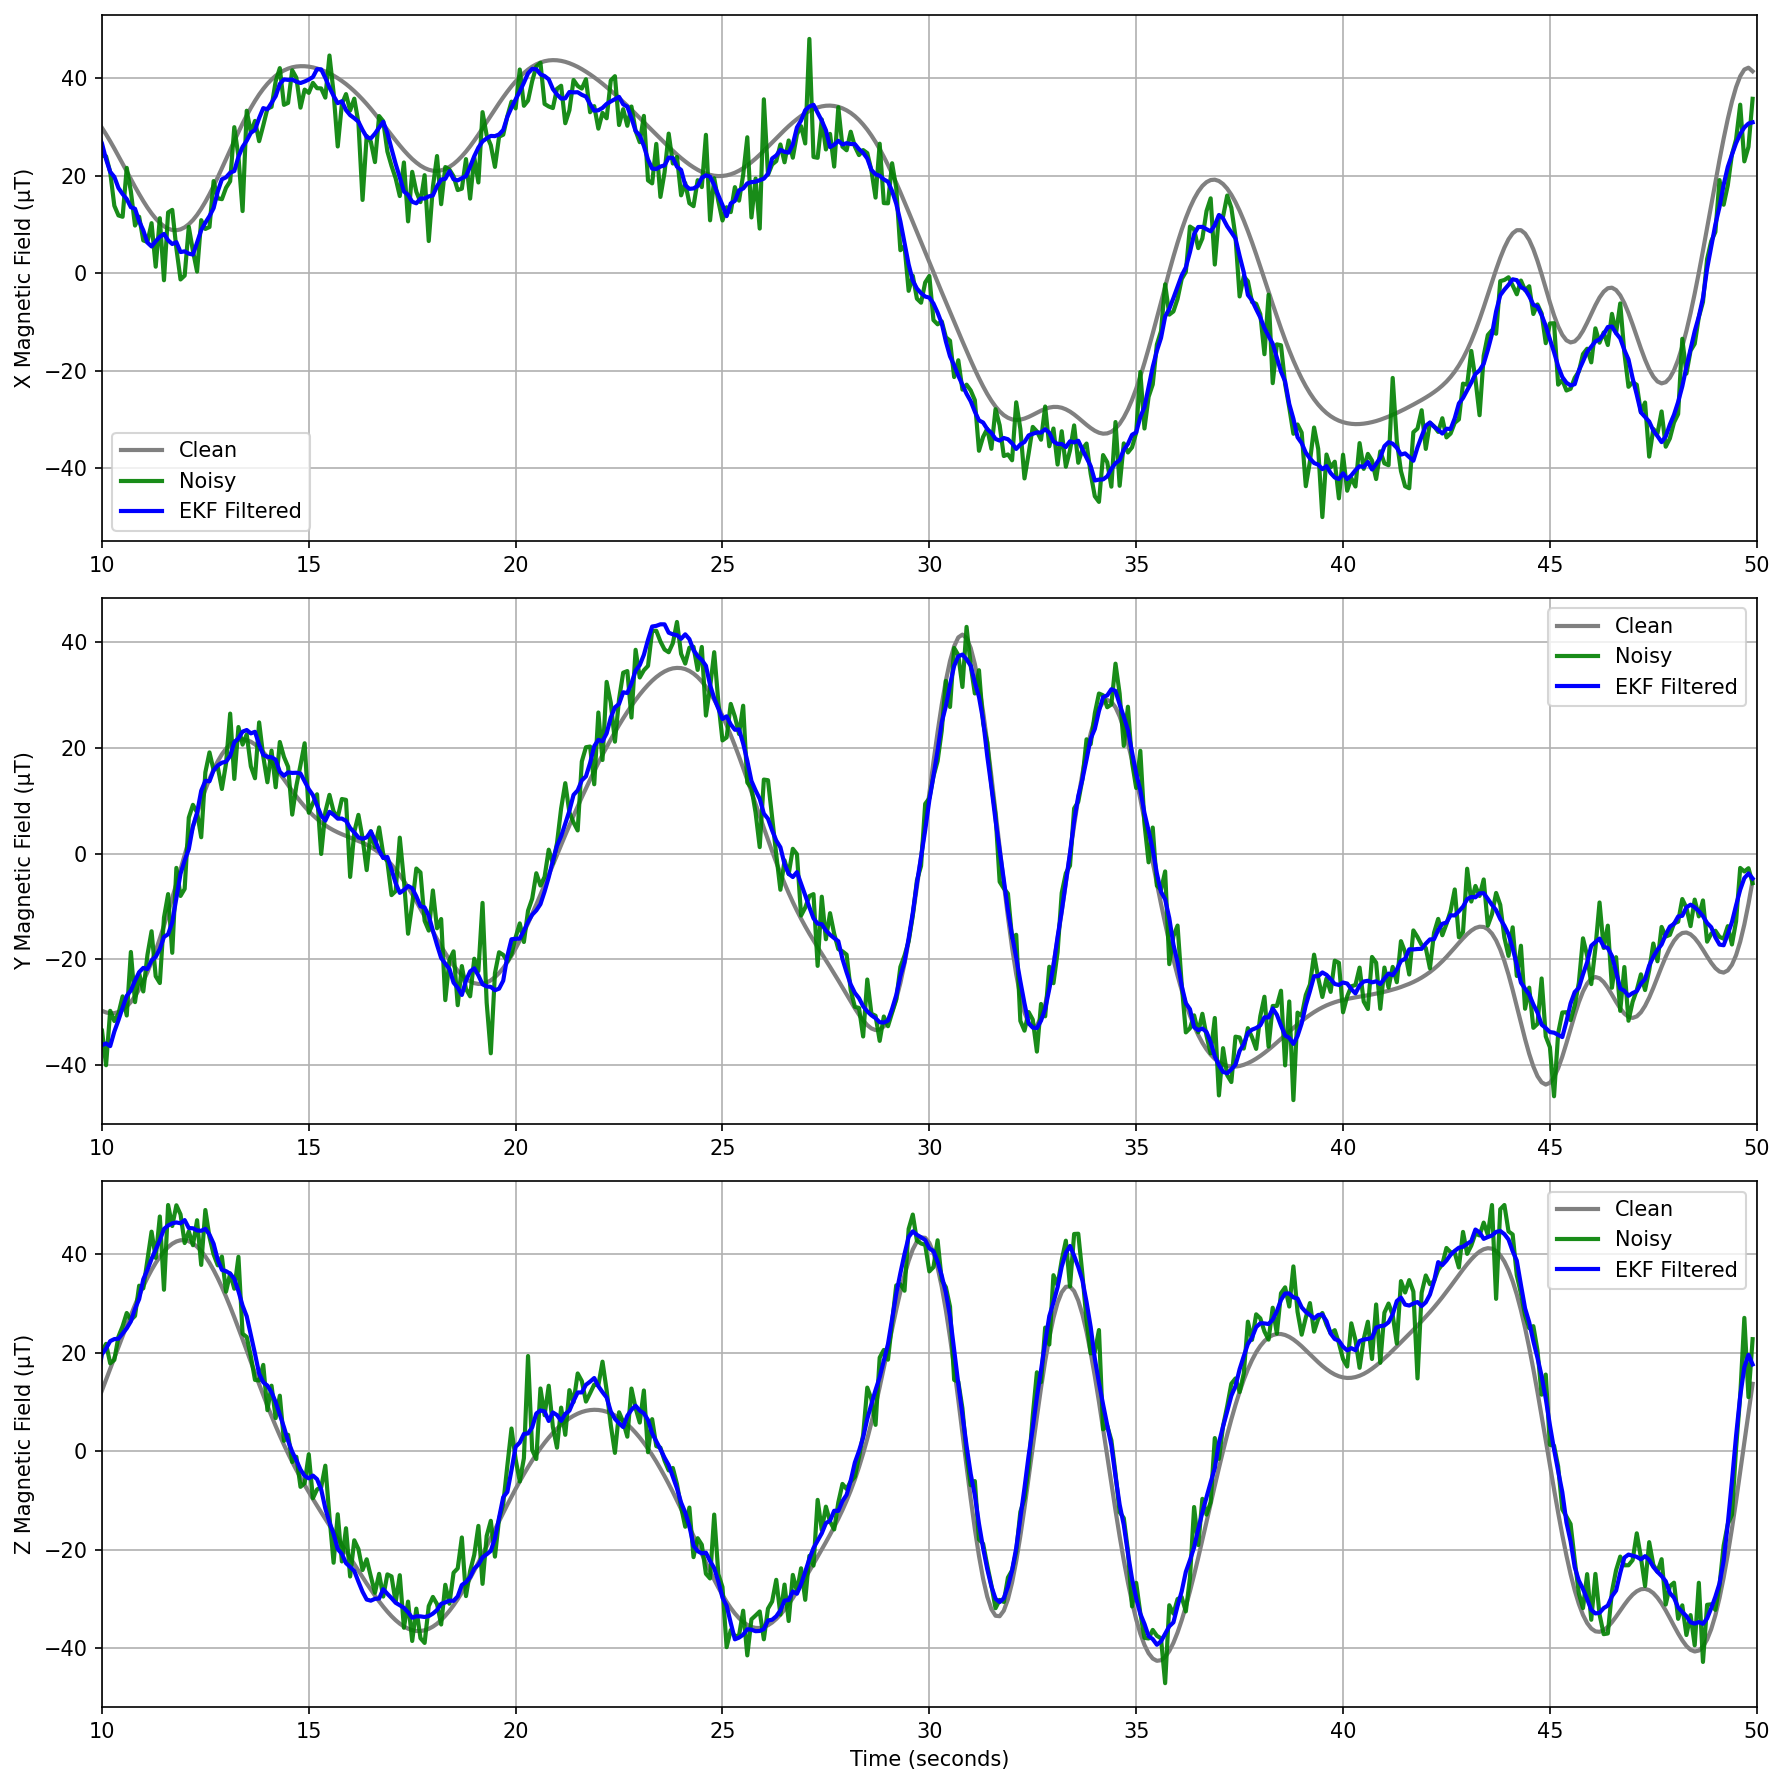


Metrics for filtered_mag_x:
Noisy RMSE: 7.901
Filtered RMSE: 6.647
RMSE Improvement: 15.9%
Noisy MAE: 6.695
Filtered MAE: 5.816
MAE Improvement: 13.1%

Metrics for filtered_mag_y:
Noisy RMSE: 5.495
Filtered RMSE: 3.987
RMSE Improvement: 27.4%
Noisy MAE: 4.445
Filtered MAE: 3.184
MAE Improvement: 28.4%

Metrics for filtered_mag_z:
Noisy RMSE: 6.151
Filtered RMSE: 4.826
RMSE Improvement: 21.5%
Noisy MAE: 5.000
Filtered MAE: 4.176
MAE Improvement: 16.5%


In [9]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from collections import deque

######################################################################
#                                                                    #
#                    DATA SETS FOR ILLUSTRATIONS                     #
#                                                                    #
#====================================================================#
#                                                                    #
#     The data from which the EKF will predict the flight path.      #
#                                                                    #
UNFILTERED_DATA_PATH = 	'satellite_data_aggressive_noise.txt'        #
#                                                                    #
#  Used to compare to filtered path to gauge accuracy of prediction. #
#                                                                    #
ACTUAL_FLIGHT_PATH = 	'satellite_data_clean.txt'                   #
#                                                                    #
#====================================================================#
#                                                                    #
#                                                                    #
######################################################################
class ResponsiveEKF:
    def __init__(self):
        self.state = np.zeros(6)
        self.covariance = np.eye(6) * 10.0
        self.dt = 0.001
        self.H = np.eye(6)
        
        # Reduced base process noise for stability
        self.Q_base = np.diag([0.05, 0.05, 0.05, 0.01, 0.01, 0.01])
        self.R_base = np.diag([0.8, 0.8, 0.8, 0.1, 0.1, 0.1])
        
        # Dynamic response parameters
        self.response_window = 5
        self.value_history = {i: deque(maxlen=self.response_window) for i in range(6)}
        self.velocity_history = {i: deque(maxlen=self.response_window) for i in range(6)}
        
        # Adaptive gains
        self.min_innovation_gain = 0.5
        self.max_innovation_gain = 2.0
        self.velocity_threshold = 0.5
        
        # Reduced damping
        self.base_damping = 0.05  # Reduced from 0.1
        
    def calculate_dynamics(self, values):
        """Calculate velocity and acceleration from recent measurements"""
        if len(values) < 3:
            return 0, 0
        
        velocity = np.diff(values)
        acceleration = np.diff(velocity)
        
        return np.mean(velocity), np.mean(acceleration)

    def adjust_gains(self, measurement):
        """Dynamically adjust filter gains based on signal behavior"""
        gains = np.ones(6)
        
        for i in range(6):
            self.value_history[i].append(measurement[i])
            velocity, acceleration = self.calculate_dynamics(list(self.value_history[i]))
            
            # Store velocity for trend analysis
            self.velocity_history[i].append(velocity)
            
            # Calculate average velocity trend
            if len(self.velocity_history[i]) >= 2:
                velocity_trend = np.mean(np.diff(list(self.velocity_history[i])))
                
                # Increase gain for rapid changes
                if abs(velocity_trend) > self.velocity_threshold:
                    gains[i] = self.max_innovation_gain
                # Reduce gain for steady regions
                else:
                    gains[i] = self.min_innovation_gain
                
                # Additional boost for acceleration
                if abs(acceleration) > self.velocity_threshold:
                    gains[i] *= 1.5
        
        return gains

    def f(self, x, gains):
        """System dynamics with adaptive damping"""
        dxdt = np.zeros(6)
        
        # Calculate adaptive damping based on state velocity
        damping = np.array([
            self.base_damping / gains[i] for i in range(6)
        ])
        
        # Modified dynamics with reduced damping
        dxdt[0] = -x[2] * x[4] + x[1] * x[5] - damping[0] * x[0]
        dxdt[1] = x[2] * x[3] - x[0] * x[5] - damping[1] * x[1]
        dxdt[2] = -x[1] * x[3] + x[0] * x[4] - damping[2] * x[2]
        dxdt[3] = -x[4] * x[5] - damping[3] * x[3]
        dxdt[4] = x[3] * x[5] - damping[4] * x[4]
        dxdt[5] = -x[3] * x[4] / 3 - damping[5] * x[5]
        
        return dxdt

    def rk4_step(self, x, step_size, gains):
        k1 = self.f(x, gains)
        k2 = self.f(x + step_size * k1 / 2, gains)
        k3 = self.f(x + step_size * k2 / 2, gains)
        k4 = self.f(x + step_size * k3, gains)
        
        if np.any(np.isnan([k1, k2, k3, k4])):
            return x
            
        return x + (step_size / 6) * (k1 + 2*k2 + 2*k3 + k4)

    def predict(self, gains):
        self.state = self.rk4_step(self.state, self.dt, gains)
        
        # Adjust process noise based on gains
        Q_adjusted = self.Q_base * np.outer(gains, gains)
        
        J = self.calculate_jacobian(self.state, gains)
        self.covariance = J @ self.covariance @ J.T + Q_adjusted
        self.covariance = (self.covariance + self.covariance.T) / 2
        
        return self.state.copy()

    def calculate_jacobian(self, x, gains):
        """Jacobian with adaptive damping"""
        Bx, By, Bz, wx, wy, wz = x
        J = np.zeros((6, 6))
        
        damping = np.array([self.base_damping / g for g in gains])
        
        J[0] = [-damping[0], wz, -wy, 0, -Bz, By]
        J[1] = [-wz, -damping[1], wx, Bz, 0, -Bx]
        J[2] = [wy, -wx, -damping[2], -By, Bx, 0]
        J[3] = [0, 0, 0, -damping[3], -wz, -wy]
        J[4] = [0, 0, 0, wz, -damping[4], wx]
        J[5] = [0, 0, 0, -wx/3, -wy/3, -damping[5]]
        
        return J

    def update(self, measurement):
        # Calculate adaptive gains
        gains = self.adjust_gains(measurement)
        
        # Predict with adaptive gains
        self.predict(gains)
        
        # Adjust measurement noise based on gains
        R_adjusted = self.R_base / np.outer(gains, gains)
        
        # Kalman gain calculation with adjusted noise
        S = self.H @ self.covariance @ self.H.T + R_adjusted
        K = self.covariance @ self.H.T @ np.linalg.inv(S)
        
        # Update state
        innovation = measurement - self.H @ self.state
        self.state = self.state + K @ innovation
        
        # Update covariance
        I = np.eye(6)
        self.covariance = (I - K @ self.H) @ self.covariance
        self.covariance = (self.covariance + self.covariance.T) / 2
        
        return self.state.copy()

# Read and process data
clean_data = pd.read_csv(ACTUAL_FLIGHT_PATH, 
                        skiprows=1,
                        header=None,
                        index_col=False, 
                        names=['pwm', 'filtered_mag_x', 'filtered_mag_y', 'filtered_mag_z', 
                               'filtered_gyro_x', 'filtered_gyro_y', 'filtered_gyro_z', 
                               'voltage'],
                        skipinitialspace=True)

noisy_data = pd.read_csv(UNFILTERED_DATA_PATH,
                        skiprows=1,
                        header=None,
                        index_col=False, 
                        names=['pwm', 'filtered_mag_x', 'filtered_mag_y', 'filtered_mag_z', 
                               'filtered_gyro_x', 'filtered_gyro_y', 'filtered_gyro_z', 
                               'voltage'],
                        skipinitialspace=True)

# Initialize and run EKF
ekf = ResponsiveEKF()
filtered_states = []

# Initialize with moving average of first few measurements
init_window = 5
init_measurements = noisy_data.iloc[:init_window][['filtered_mag_x', 'filtered_mag_y', 'filtered_mag_z',
                                                  'filtered_gyro_x', 'filtered_gyro_y', 'filtered_gyro_z']].mean()
ekf.state = init_measurements.values

# Process data
for _, row in noisy_data.iterrows():
    measurement = np.array([
        row['filtered_mag_x'],
        row['filtered_mag_y'],
        row['filtered_mag_z'],
        row['filtered_gyro_x'],
        row['filtered_gyro_y'],
        row['filtered_gyro_z']
    ])
    
    filtered_state = ekf.update(measurement)
    filtered_states.append(filtered_state)

# Convert to DataFrame
filtered_data = pd.DataFrame(filtered_states, columns=[
    'filtered_mag_x', 'filtered_mag_y', 'filtered_mag_z',
    'filtered_gyro_x', 'filtered_gyro_y', 'filtered_gyro_z'
])

# Minimal smoothing to preserve dynamics
window = 11  # Reduced window size
order = 3
for col in filtered_data.columns:
    filtered_data[col] = savgol_filter(filtered_data[col], window, order)

# Create plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), dpi=150)
time = clean_data.index * 0.1

# Plot components
for ax, component, ylabel in zip(
    [ax1, ax2, ax3],
    ['filtered_mag_x', 'filtered_mag_y', 'filtered_mag_z'],
    ['X Magnetic Field (μT)', 'Y Magnetic Field (μT)', 'Z Magnetic Field (μT)']
):
    ax.plot(time, clean_data[component], color='grey', label='Clean', linewidth=2)
    ax.plot(time, noisy_data[component], color='green', alpha=0.9, label='Noisy', linewidth=2)
    ax.plot(time, filtered_data[component], color='blue', label='EKF Filtered', linewidth=2)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.set_xlim(10, 50)
    ax.grid(True)

ax3.set_xlabel('Time (seconds)')
plt.tight_layout()
plt.show()

# Calculate and print metrics
def calculate_metrics(clean, noisy, filtered):
    noisy_rmse = np.sqrt(np.mean((clean - noisy) ** 2))
    filtered_rmse = np.sqrt(np.mean((clean - filtered) ** 2))
    noisy_mae = np.mean(np.abs(clean - noisy))
    filtered_mae = np.mean(np.abs(clean - filtered))
    
    improvement_rmse = (noisy_rmse - filtered_rmse) / noisy_rmse * 100
    improvement_mae = (noisy_mae - filtered_mae) / noisy_mae * 100
    
    return noisy_rmse, filtered_rmse, noisy_mae, filtered_mae, improvement_rmse, improvement_mae

components = ['filtered_mag_x', 'filtered_mag_y', 'filtered_mag_z']
for component in components:
    noisy_rmse, filtered_rmse, noisy_mae, filtered_mae, imp_rmse, imp_mae = calculate_metrics(
        clean_data[component], 
        noisy_data[component], 
        filtered_data[component]
    )
    print(f"\nMetrics for {component}:")
    print(f"Noisy RMSE: {noisy_rmse:.3f}")
    print(f"Filtered RMSE: {filtered_rmse:.3f}")
    print(f"RMSE Improvement: {imp_rmse:.1f}%")
    print(f"Noisy MAE: {noisy_mae:.3f}")
    print(f"Filtered MAE: {filtered_mae:.3f}")
    print(f"MAE Improvement: {imp_mae:.1f}%")

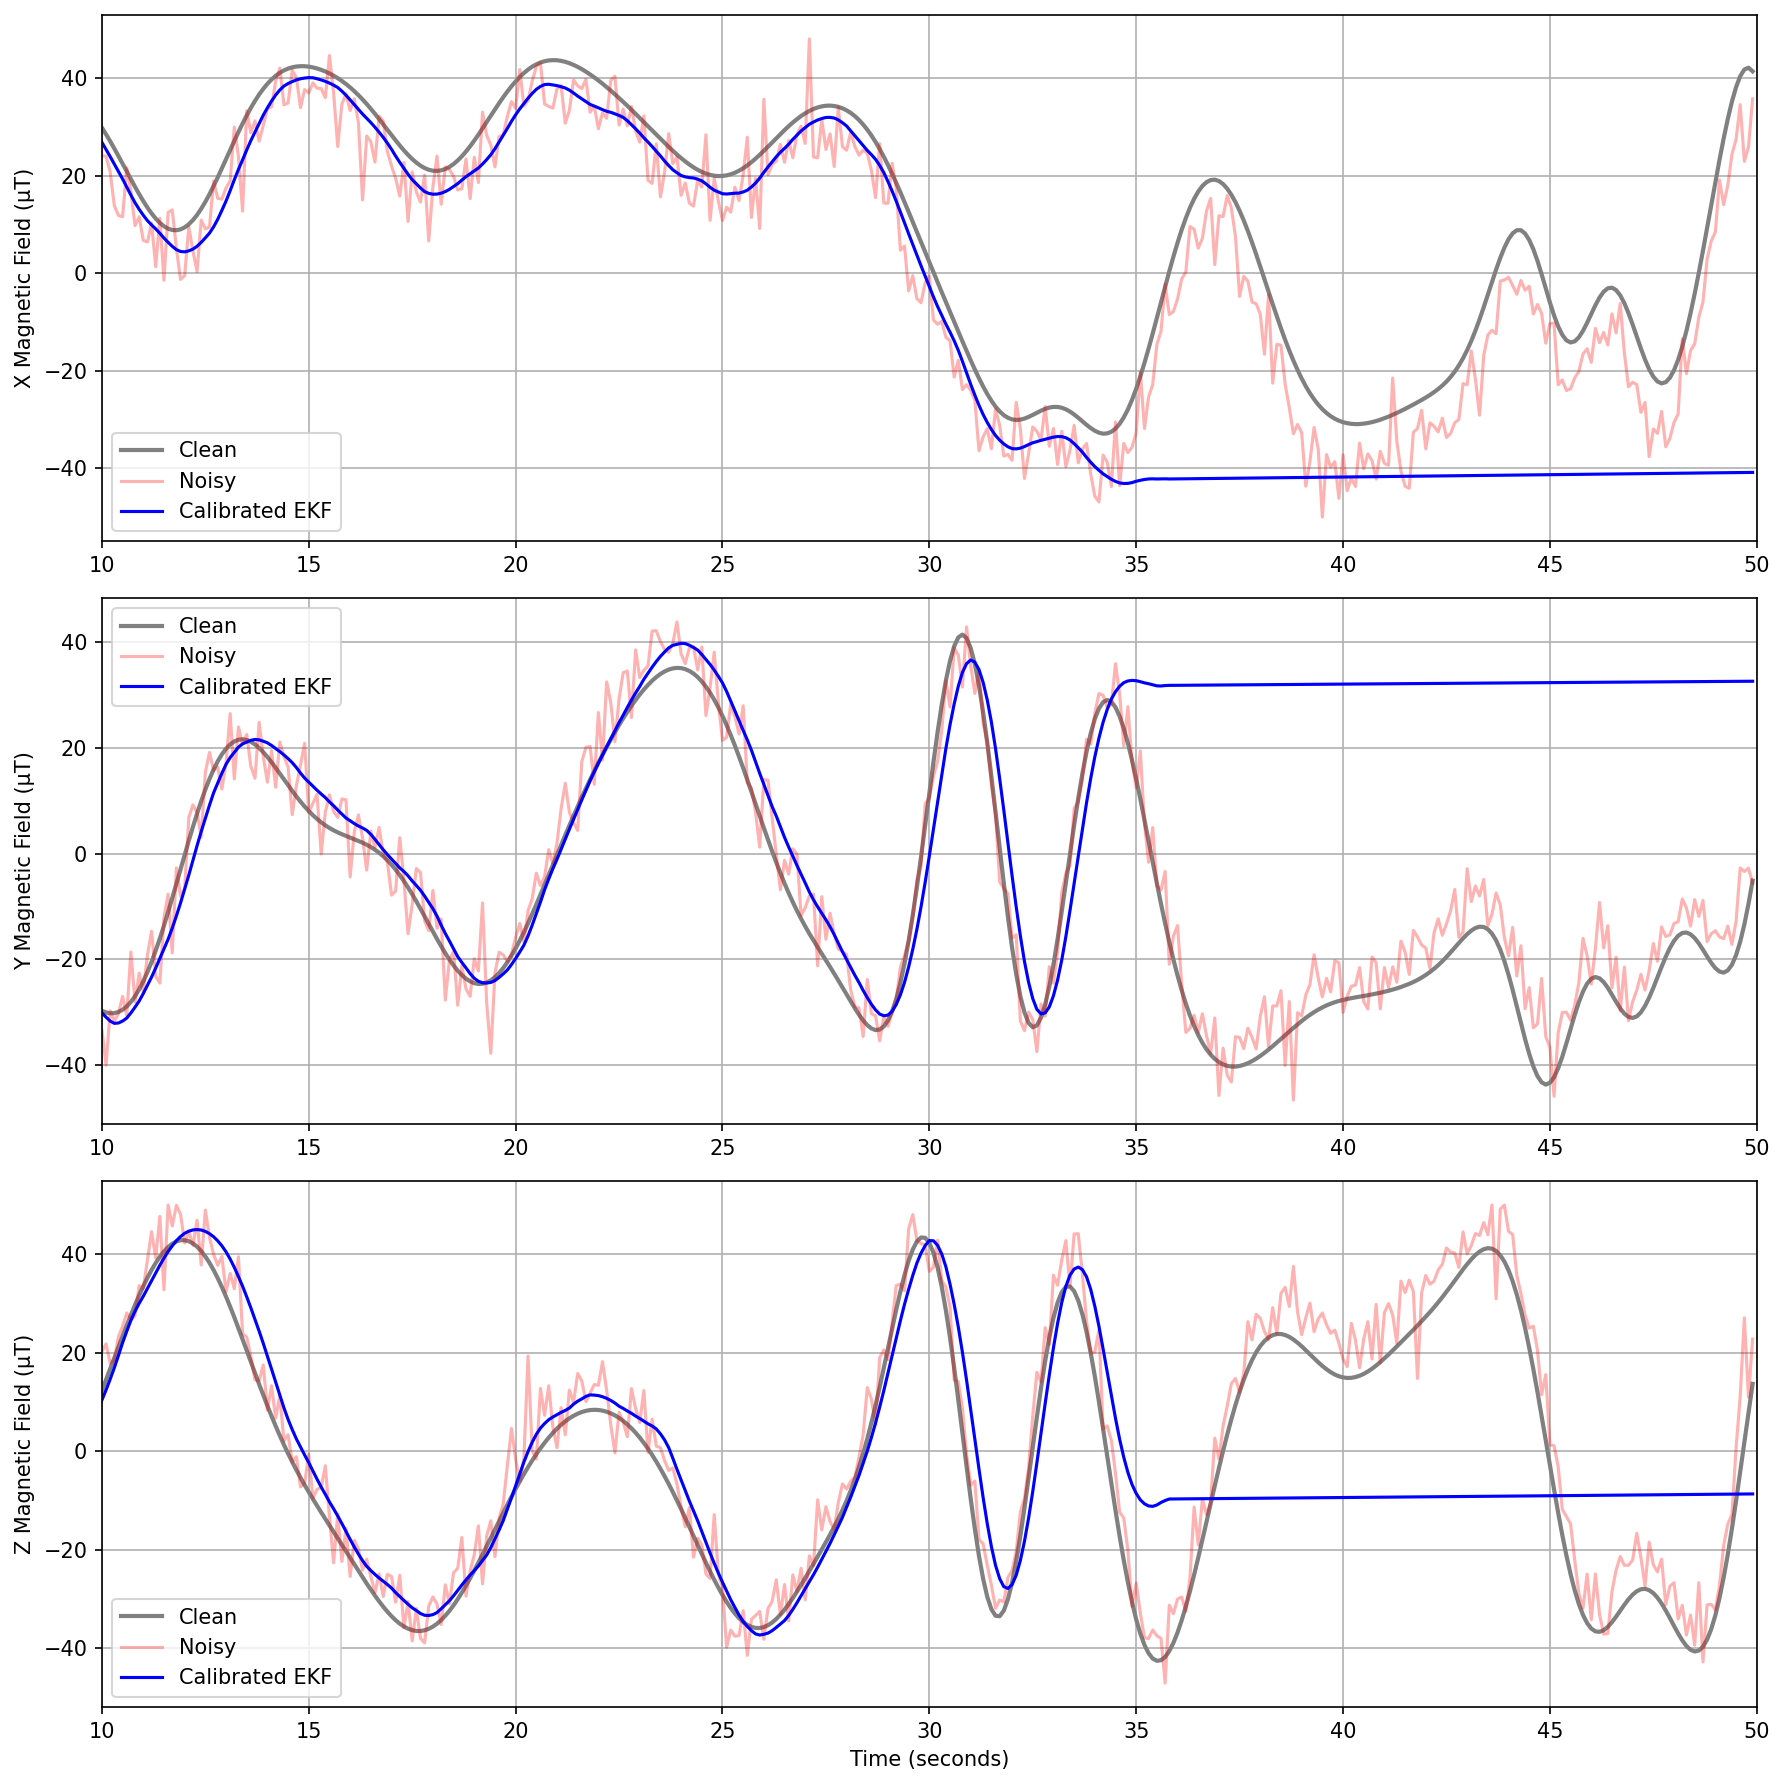


Metrics for filtered_mag_x:
Noisy RMSE: 7.901
Filtered RMSE: 21.660
RMSE Improvement: -174.1%
Noisy MAE: 6.695
Filtered MAE: 13.207
MAE Improvement: -97.3%

Metrics for filtered_mag_y:
Noisy RMSE: 5.495
Filtered RMSE: 32.449
RMSE Improvement: -490.5%
Noisy MAE: 4.445
Filtered MAE: 20.196
MAE Improvement: -354.3%

Metrics for filtered_mag_z:
Noisy RMSE: 6.151
Filtered RMSE: 16.779
RMSE Improvement: -172.8%
Noisy MAE: 5.000
Filtered MAE: 11.422
MAE Improvement: -128.4%


In [10]:
######################################################################
#																	 #
#		POORLY IMPLEMENTED EKF, DIVERGENT PREDICTION CAUSED BY       #
#		FIXED NOISE PERAMETERS (Q & R MATRICES)                      #
#		* This implementation lack the ability to adapt to           #
#       the changing signal dynaimics like the implementation above. #
#																	 #
######################################################################

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import Dict, Callable

# Constants
MIN_VOLTAGE = 3.6
MAX_VOLTAGE = 4.2
VOLTAGE_STEP = 0.1

class CalibratedEKF:
    def __init__(self):
        # Significantly increased initial covariance to be more responsive at start
        self.state = np.zeros(6)
        self.covariance = np.eye(6) * 10.0
        
        # Decreased time step for better numerical stability
        self.dt = 0.001
        
        # Adjusted noise parameters
        # Increased process noise for magnetic field components
        self.Q = np.diag([0.1, 0.1, 0.1, 0.01, 0.01, 0.01])
        
        # Decreased measurement noise to trust measurements less
        self.R = np.diag([1.0, 1.0, 1.0, 0.1, 0.1, 0.1])
        
        self.H = np.eye(6)
        
        # Innovation threshold for outlier detection
        self.innovation_threshold = 5.0
        
        # Exponential smoothing factor for adaptive filtering
        self.alpha = 0.3
        
        # Moving average window for smoothing
        self.window_size = 5
        self.measurement_history = []
        
    def f(self, x):
        """System dynamics function with improved numerical stability"""
        dxdt = np.zeros(6)
        
        # Add damping terms to prevent instability
        damping = 0.1
        dxdt[0] = -x[2] * x[4] + x[1] * x[5] - damping * x[0]
        dxdt[1] = x[2] * x[3] - x[0] * x[5] - damping * x[1]
        dxdt[2] = -x[1] * x[3] + x[0] * x[4] - damping * x[2]
        dxdt[3] = -x[4] * x[5] - damping * x[3]
        dxdt[4] = x[3] * x[5] - damping * x[4]
        dxdt[5] = -x[3] * x[4] / 3 - damping * x[5]
        
        return dxdt

    def rk4_step(self, x, step_size):
        """RK4 integration with stability checks"""
        k1 = self.f(x)
        k2 = self.f(x + step_size * k1 / 2)
        k3 = self.f(x + step_size * k2 / 2)
        k4 = self.f(x + step_size * k3)
        
        # Check for numerical instability
        if np.any(np.isnan([k1, k2, k3, k4])):
            return x  # Return unchanged state if unstable
            
        return x + (step_size / 6) * (k1 + 2*k2 + 2*k3 + k4)

    def calculate_jacobian(self, x):
        """Calculate Jacobian with stability constraints"""
        Bx, By, Bz, wx, wy, wz = x
        J = np.zeros((6, 6))
        
        # Add damping terms to diagonal elements
        damping = 0.1
        J[0] = [-damping, wz, -wy, 0, -Bz, By]
        J[1] = [-wz, -damping, wx, Bz, 0, -Bx]
        J[2] = [wy, -wx, -damping, -By, Bx, 0]
        J[3] = [0, 0, 0, -damping, -wz, -wy]
        J[4] = [0, 0, 0, wz, -damping, wx]
        J[5] = [0, 0, 0, -wx/3, -wy/3, -damping]
        
        return J

    def predict(self):
        """Prediction step with error checking"""
        predicted_state = self.rk4_step(self.state, self.dt)
        
        # Check for reasonable state values
        if np.all(np.abs(predicted_state) < 100):  # Reasonable threshold
            self.state = predicted_state
        
        J = self.calculate_jacobian(self.state)
        self.covariance = J @ self.covariance @ J.T + self.Q
        
        # Ensure covariance stays positive definite
        self.covariance = (self.covariance + self.covariance.T) / 2
        
        return self.state.copy()

    def update(self, measurement, voltage, pwm):
        """Update step with robust outlier rejection and adaptive filtering"""
        # Store measurement in history
        self.measurement_history.append(measurement)
        if len(self.measurement_history) > self.window_size:
            self.measurement_history.pop(0)
        
        # Calculate moving average of measurements
        smoothed_measurement = np.mean(self.measurement_history, axis=0)
        
        # Innovation calculation
        innovation = smoothed_measurement - self.H @ self.state
        innovation_magnitude = np.linalg.norm(innovation)
        
        # Adaptive measurement noise
        if innovation_magnitude > self.innovation_threshold:
            R_adaptive = self.R * (innovation_magnitude / self.innovation_threshold)
        else:
            R_adaptive = self.R
        
        # Kalman gain calculation
        S = self.H @ self.covariance @ self.H.T + R_adaptive
        K = self.covariance @ self.H.T @ np.linalg.inv(S)
        
        # State update with outlier rejection
        if innovation_magnitude < self.innovation_threshold * 2:
            self.state = self.state + K @ innovation
        
        # Covariance update
        I = np.eye(6)
        self.covariance = (I - K @ self.H) @ self.covariance
        
        # Ensure covariance stays positive definite
        self.covariance = (self.covariance + self.covariance.T) / 2
        
        return self.state.copy()

# Read and process data
clean_data = pd.read_csv('satellite_data_clean.txt', 
                        skiprows=1,
                        header=None,
                        index_col=False, 
                        names=['pwm', 'filtered_mag_x', 'filtered_mag_y', 'filtered_mag_z', 
                               'filtered_gyro_x', 'filtered_gyro_y', 'filtered_gyro_z', 
                               'voltage'],
                        skipinitialspace=True)

noisy_data = pd.read_csv('satellite_data_aggressive_noise.txt',
                        skiprows=1,
                        header=None,
                        index_col=False, 
                        names=['pwm', 'filtered_mag_x', 'filtered_mag_y', 'filtered_mag_z', 
                               'filtered_gyro_x', 'filtered_gyro_y', 'filtered_gyro_z', 
                               'voltage'],
                        skipinitialspace=True)

# Initialize and run EKF
ekf = CalibratedEKF()
filtered_states = []

# Initialize with moving average of first few measurements
init_window = 5
init_measurements = noisy_data.iloc[:init_window][['filtered_mag_x', 'filtered_mag_y', 'filtered_mag_z',
                                                  'filtered_gyro_x', 'filtered_gyro_y', 'filtered_gyro_z']].mean()
ekf.state = init_measurements.values

for _, row in noisy_data.iterrows():
    measurement = np.array([
        row['filtered_mag_x'],
        row['filtered_mag_y'],
        row['filtered_mag_z'],
        row['filtered_gyro_x'],
        row['filtered_gyro_y'],
        row['filtered_gyro_z']
    ])
    
    ekf.predict()
    filtered_state = ekf.update(measurement, row['voltage'], row['pwm'])
    filtered_states.append(filtered_state)

# Convert to DataFrame and apply additional smoothing
filtered_data = pd.DataFrame(filtered_states, columns=[
    'filtered_mag_x', 'filtered_mag_y', 'filtered_mag_z',
    'filtered_gyro_x', 'filtered_gyro_y', 'filtered_gyro_z'
])

# Apply Savitzky-Golay filter for final smoothing
from scipy.signal import savgol_filter
window = 21  # Must be odd
order = 3

for col in filtered_data.columns:
    filtered_data[col] = savgol_filter(filtered_data[col], window, order)

# Create plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), dpi=150)
time = clean_data.index * 0.1

# Plot X component
ax1.plot(time, clean_data['filtered_mag_x'], color='grey', label='Clean', linewidth=2)
ax1.plot(time, noisy_data['filtered_mag_x'], color='red', alpha=0.3, label='Noisy')
ax1.plot(time, filtered_data['filtered_mag_x'], color='blue', label='Calibrated EKF')
ax1.set_ylabel('X Magnetic Field (μT)')
ax1.legend()
ax1.set_xlim(10, 50)
ax1.grid(True)

# Plot Y component
ax2.plot(time, clean_data['filtered_mag_y'], color='grey', label='Clean', linewidth=2)
ax2.plot(time, noisy_data['filtered_mag_y'], color='red', alpha=0.3, label='Noisy')
ax2.plot(time, filtered_data['filtered_mag_y'], color='blue', label='Calibrated EKF')
ax2.set_ylabel('Y Magnetic Field (μT)')
ax2.legend()
ax2.set_xlim(10, 50)
ax2.grid(True)

# Plot Z component
ax3.plot(time, clean_data['filtered_mag_z'], color='grey', label='Clean', linewidth=2)
ax3.plot(time, noisy_data['filtered_mag_z'], color='red', alpha=0.3, label='Noisy')
ax3.plot(time, filtered_data['filtered_mag_z'], color='blue', label='Calibrated EKF')
ax3.set_xlabel('Time (seconds)')
ax3.set_ylabel('Z Magnetic Field (μT)')
ax3.legend()
ax3.set_xlim(10, 50)
ax3.grid(True)

plt.tight_layout()
plt.show()

# Calculate error metrics
def calculate_metrics(clean, noisy, filtered):
    noisy_rmse = np.sqrt(np.mean((clean - noisy) ** 2))
    filtered_rmse = np.sqrt(np.mean((clean - filtered) ** 2))
    noisy_mae = np.mean(np.abs(clean - noisy))
    filtered_mae = np.mean(np.abs(clean - filtered))
    
    improvement_rmse = (noisy_rmse - filtered_rmse) / noisy_rmse * 100
    improvement_mae = (noisy_mae - filtered_mae) / noisy_mae * 100
    
    return noisy_rmse, filtered_rmse, noisy_mae, filtered_mae, improvement_rmse, improvement_mae

# Print metrics
components = ['filtered_mag_x', 'filtered_mag_y', 'filtered_mag_z']
for component in components:
    noisy_rmse, filtered_rmse, noisy_mae, filtered_mae, imp_rmse, imp_mae = calculate_metrics(
        clean_data[component], 
        noisy_data[component], 
        filtered_data[component]
    )
    print(f"\nMetrics for {component}:")
    print(f"Noisy RMSE: {noisy_rmse:.3f}")
    print(f"Filtered RMSE: {filtered_rmse:.3f}")
    print(f"RMSE Improvement: {imp_rmse:.1f}%")
    print(f"Noisy MAE: {noisy_mae:.3f}")
    print(f"Filtered MAE: {filtered_mae:.3f}")
    print(f"MAE Improvement: {imp_mae:.1f}%")

Filter reset triggered
Filter reset triggered
Filter reset triggered


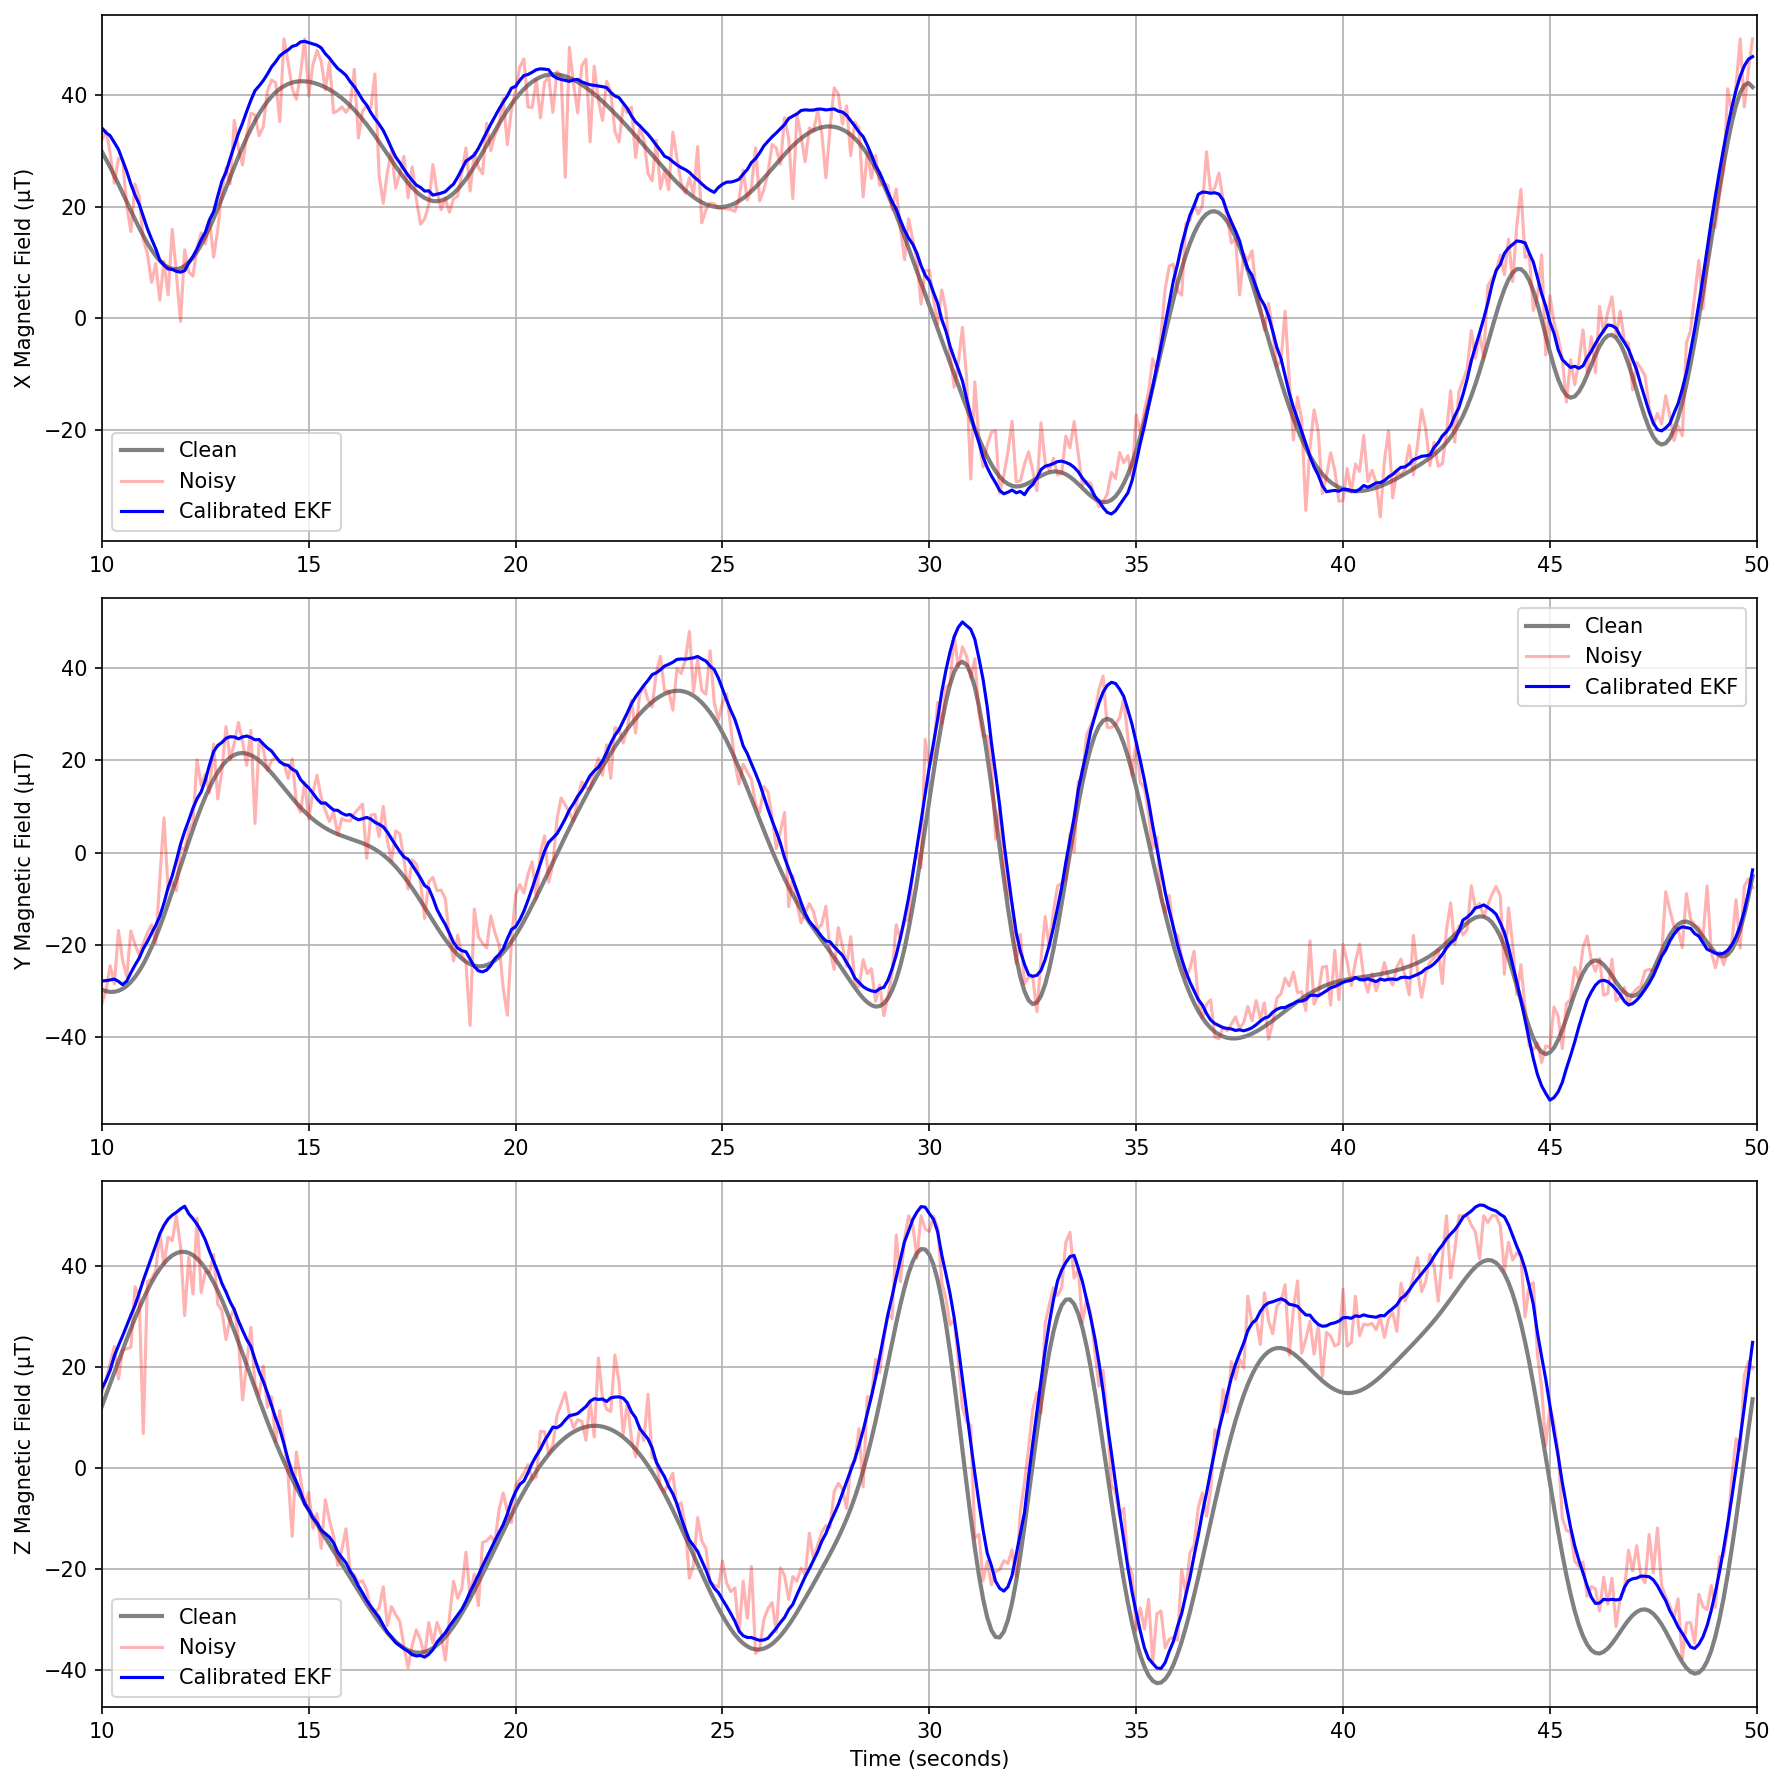


Metrics for filtered_mag_x:
Noisy RMSE: 4.940
Filtered RMSE: 3.577
RMSE Improvement: 27.6%
Noisy MAE: 3.837
Filtered MAE: 3.114
MAE Improvement: 18.9%

Metrics for filtered_mag_y:
Noisy RMSE: 5.566
Filtered RMSE: 4.918
RMSE Improvement: 11.6%
Noisy MAE: 4.398
Filtered MAE: 4.073
MAE Improvement: 7.4%

Metrics for filtered_mag_z:
Noisy RMSE: 7.963
Filtered RMSE: 7.181
RMSE Improvement: 9.8%
Noisy MAE: 6.546
Filtered MAE: 5.712
MAE Improvement: 12.7%


In [51]:
######################################################################
#																	 #
#		SLIGHTLY IMPROVED IMPLEMENTATION OF EKF, UTILIZES RESET      #
#		FIXED NOISE PERAMETERS (Q & R MATRICES)                      #
#		* This implementation is similar to the implementation above #
#		  the key difference being that when the prediction diverges #
#         at a predetermined threshold a reset is triggered.         #
#																	 #
######################################################################

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import Dict, Callable

# Constants
MIN_VOLTAGE = 3.6
MAX_VOLTAGE = 4.2
VOLTAGE_STEP = 0.1

class CalibratedEKF:
	def __init__(self):
		self.state = np.zeros(6)
		self.covariance = np.eye(6) * 10.0
		self.dt = 0.001
		self.Q = np.diag([0.1, 0.1, 0.1, 0.01, 0.01, 0.01])
		self.R = np.diag([1.0, 1.0, 1.0, 0.1, 0.1, 0.1])
		self.H = np.eye(6)
		
		# Parameters for reset mechanism
		self.max_innovation_count = 12  # Number of consecutive large innovations before reset
		self.innovation_threshold = 9.0
		self.current_innovation_count = 0
		self.max_state_magnitude = 70.0  # Maximum allowed magnitude for state variables
		
		# Storage for reset mechanism
		self.last_valid_state = None
		self.measurement_buffer = []
		self.buffer_size = 10
		
	def reset_filter(self, measurement):
		"""Reset the filter state using recent measurements"""
		# Use moving average of recent measurements as new state
		if len(self.measurement_buffer) > 0:
			new_state = np.mean(self.measurement_buffer, axis=0)
		else:
			new_state = measurement
			
		self.state = new_state
		self.covariance = np.eye(6) * 10.0  # Reset covariance
		self.current_innovation_count = 0
		print("Filter reset triggered")
		
	def check_state_validity(self):
		"""Check if current state estimate is valid"""
		# Check for NaN or infinite values
		if np.any(np.isnan(self.state)) or np.any(np.isinf(self.state)):
			return False
			
		# Check for unreasonably large values
		if np.any(np.abs(self.state) > self.max_state_magnitude):
			return False
			
		return True
		
	def f(self, x):
		"""System dynamics function with improved numerical stability"""
		dxdt = np.zeros(6)
		
		# Add damping terms to prevent instability
		damping = 0.1
		dxdt[0] = -x[2] * x[4] + x[1] * x[5] - damping * x[0]
		dxdt[1] = x[2] * x[3] - x[0] * x[5] - damping * x[1]
		dxdt[2] = -x[1] * x[3] + x[0] * x[4] - damping * x[2]
		dxdt[3] = -x[4] * x[5] - damping * x[3]
		dxdt[4] = x[3] * x[5] - damping * x[4]
		dxdt[5] = -x[3] * x[4] / 3 - damping * x[5]
		
		return dxdt

	def rk4_step(self, x, step_size):
		"""RK4 integration with stability checks"""
		k1 = self.f(x)
		k2 = self.f(x + step_size * k1 / 2)
		k3 = self.f(x + step_size * k2 / 2)
		k4 = self.f(x + step_size * k3)
		
		# Check for numerical instability
		if np.any(np.isnan([k1, k2, k3, k4])):
			return x  # Return unchanged state if unstable
			
		return x + (step_size / 6) * (k1 + 2*k2 + 2*k3 + k4)

	def calculate_jacobian(self, x):
		"""Calculate Jacobian with stability constraints"""
		Bx, By, Bz, wx, wy, wz = x
		J = np.zeros((6, 6))
		
		# Add damping terms to diagonal elements
		damping = 0.1
		J[0] = [-damping, wz, -wy, 0, -Bz, By]
		J[1] = [-wz, -damping, wx, Bz, 0, -Bx]
		J[2] = [wy, -wx, -damping, -By, Bx, 0]
		J[3] = [0, 0, 0, -damping, -wz, -wy]
		J[4] = [0, 0, 0, wz, -damping, wx]
		J[5] = [0, 0, 0, -wx/3, -wy/3, -damping]
		
		return J

	def predict(self):
		"""Prediction step with error checking"""
		predicted_state = self.rk4_step(self.state, self.dt)
		
		# Check for reasonable state values
		if np.all(np.abs(predicted_state) < 100):  # Reasonable threshold
			self.state = predicted_state
		
		J = self.calculate_jacobian(self.state)
		self.covariance = J @ self.covariance @ J.T + self.Q
		
		# Ensure covariance stays positive definite
		self.covariance = (self.covariance + self.covariance.T) / 2
		
		return self.state.copy()

	def update(self, measurement, voltage, pwm):
		"""Update step with robust outlier rejection and reset mechanism"""
		# Update measurement buffer
		self.measurement_buffer.append(measurement)
		if len(self.measurement_buffer) > self.buffer_size:
			self.measurement_buffer.pop(0)
			
		# Store last valid state
		if self.check_state_validity():
			self.last_valid_state = self.state.copy()
			
		# Innovation calculation
		innovation = measurement - self.H @ self.state
		innovation_magnitude = np.linalg.norm(innovation)
		
		# Check for filter divergence
		if innovation_magnitude > self.innovation_threshold:
			self.current_innovation_count += 1
		else:
			self.current_innovation_count = 0
			
		# Reset filter if necessary
		if (self.current_innovation_count >= self.max_innovation_count or 
			not self.check_state_validity()):
			self.reset_filter(measurement)
			return self.state.copy()
			
		# Regular Kalman filter update
		S = self.H @ self.covariance @ self.H.T + self.R
		K = self.covariance @ self.H.T @ np.linalg.inv(S)
		
		# State update with bounds checking
		new_state = self.state + K @ innovation
		if np.all(np.abs(new_state) < self.max_state_magnitude):
			self.state = new_state
		elif self.last_valid_state is not None:
			self.state = self.last_valid_state
			
		# Covariance update
		I = np.eye(6)
		self.covariance = (I - K @ self.H) @ self.covariance
		self.covariance = (self.covariance + self.covariance.T) / 2
		
		return self.state.copy()

# Read and process data
clean_data = pd.read_csv('satellite_data_clean.txt', 
						skiprows=1,
						header=None,
						index_col=False, 
						names=['pwm', 'filtered_mag_x', 'filtered_mag_y', 'filtered_mag_z', 
							   'filtered_gyro_x', 'filtered_gyro_y', 'filtered_gyro_z', 
							   'voltage'],
						skipinitialspace=True)

noisy_data = pd.read_csv('satellite_data_aggressive_noise.txt',
						skiprows=1,
						header=None,
						index_col=False, 
						names=['pwm', 'filtered_mag_x', 'filtered_mag_y', 'filtered_mag_z', 
							   'filtered_gyro_x', 'filtered_gyro_y', 'filtered_gyro_z', 
							   'voltage'],
						skipinitialspace=True)

# Initialize and run EKF
ekf = CalibratedEKF()
filtered_states = []

# Initialize with moving average of first few measurements
init_window = 5
init_measurements = noisy_data.iloc[:init_window][['filtered_mag_x', 'filtered_mag_y', 'filtered_mag_z',
												  'filtered_gyro_x', 'filtered_gyro_y', 'filtered_gyro_z']].mean()
ekf.state = init_measurements.values

for _, row in noisy_data.iterrows():
	measurement = np.array([
		row['filtered_mag_x'],
		row['filtered_mag_y'],
		row['filtered_mag_z'],
		row['filtered_gyro_x'],
		row['filtered_gyro_y'],
		row['filtered_gyro_z']
	])
		
	ekf.predict()
	filtered_state = ekf.update(measurement, row['voltage'], row['pwm'])
	filtered_states.append(filtered_state)

# Convert to DataFrame and apply additional smoothing
filtered_data = pd.DataFrame(filtered_states, columns=[
	'filtered_mag_x', 'filtered_mag_y', 'filtered_mag_z',
	'filtered_gyro_x', 'filtered_gyro_y', 'filtered_gyro_z'
])

# Apply Savitzky-Golay filter for final smoothing
from scipy.signal import savgol_filter
window = 21  # Must be odd
order = 3

for col in filtered_data.columns:
	filtered_data[col] = savgol_filter(filtered_data[col], window, order)

# Create plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), dpi=150)
time = clean_data.index * 0.1

# Plot X component
ax1.plot(time, clean_data['filtered_mag_x'], color='grey', label='Clean', linewidth=2)
ax1.plot(time, noisy_data['filtered_mag_x'], color='red', alpha=0.3, label='Noisy')
ax1.plot(time, filtered_data['filtered_mag_x'], color='blue', label='Calibrated EKF')
ax1.set_ylabel('X Magnetic Field (μT)')
ax1.legend()
ax1.set_xlim(10, 50)
ax1.grid(True)

# Plot Y component
ax2.plot(time, clean_data['filtered_mag_y'], color='grey', label='Clean', linewidth=2)
ax2.plot(time, noisy_data['filtered_mag_y'], color='red', alpha=0.3, label='Noisy')
ax2.plot(time, filtered_data['filtered_mag_y'], color='blue', label='Calibrated EKF')
ax2.set_ylabel('Y Magnetic Field (μT)')
ax2.legend()
ax2.set_xlim(10, 50)
ax2.grid(True)

# Plot Z component
ax3.plot(time, clean_data['filtered_mag_z'], color='grey', label='Clean', linewidth=2)
ax3.plot(time, noisy_data['filtered_mag_z'], color='red', alpha=0.3, label='Noisy')
ax3.plot(time, filtered_data['filtered_mag_z'], color='blue', label='Calibrated EKF')
ax3.set_xlabel('Time (seconds)')
ax3.set_ylabel('Z Magnetic Field (μT)')
ax3.legend()
ax3.set_xlim(10, 50)
ax3.grid(True)

plt.tight_layout()
plt.show()

# Calculate error metrics
def calculate_metrics(clean, noisy, filtered):
	noisy_rmse = np.sqrt(np.mean((clean - noisy) ** 2))
	filtered_rmse = np.sqrt(np.mean((clean - filtered) ** 2))
	noisy_mae = np.mean(np.abs(clean - noisy))
	filtered_mae = np.mean(np.abs(clean - filtered))

	improvement_rmse = (noisy_rmse - filtered_rmse) / noisy_rmse * 100
	improvement_mae = (noisy_mae - filtered_mae) / noisy_mae * 100
		
	return noisy_rmse, filtered_rmse, noisy_mae, filtered_mae, improvement_rmse, improvement_mae

# Print metrics
components = ['filtered_mag_x', 'filtered_mag_y', 'filtered_mag_z']
for component in components:
	noisy_rmse, filtered_rmse, noisy_mae, filtered_mae, imp_rmse, imp_mae = calculate_metrics(
		clean_data[component], 
		noisy_data[component], 
		filtered_data[component]
	)
	print(f"\nMetrics for {component}:")
	print(f"Noisy RMSE: {noisy_rmse:.3f}")
	print(f"Filtered RMSE: {filtered_rmse:.3f}")
	print(f"RMSE Improvement: {imp_rmse:.1f}%")
	print(f"Noisy MAE: {noisy_mae:.3f}")
	print(f"Filtered MAE: {filtered_mae:.3f}")
	print(f"MAE Improvement: {imp_mae:.1f}%")

In [52]:
################################################################################
#                                                                              #
#        USE THIS SEGMENT OF CODE TO GENERATE `SATELLITE_DATA_CLEAN.TXT`       #
#                                                                              #
#      generate the clean rotation from which to add noise for filtering       #
#                                                                              #
################################################################################

import numpy as np

# Time settings
dt = 0.1  # 100ms between measurements
t = np.arange(0, 50, dt)  # 50 seconds of data
n_points = len(t)

# Initial conditions for tumbling
omega0 = np.array([0.2, 0.3, 0.1])  # Initial angular velocities (rad/s)
# Principal moments of inertia (kg·m²) - typical CubeSat values
I = np.array([0.005, 0.006, 0.004])

# Generate smooth angular velocities with some natural variation
def generate_angular_velocities(t, omega0):
	# Add some natural nutation and precession
	wx = omega0[0] * np.cos(0.1 * t) + 0.05 * np.sin(0.3 * t)
	wy = omega0[1] * np.cos(0.15 * t) + 0.05 * np.sin(0.25 * t)
	wz = omega0[2] * np.cos(0.2 * t) + 0.05 * np.sin(0.35 * t)
	return np.column_stack((wx, wy, wz))

# Generate angular velocities
angular_velocities = generate_angular_velocities(t, omega0)

# Initial magnetic field vector in body frame
B0 = np.array([30.0, 25.0, 20.0])  # Initial magnetic field (μT)

# Generate magnetic field measurements with rotation
def rotate_vector(vector, omega, t):
	# Simple rotation matrix based on angular velocities
	theta = omega * t
	Rx = np.array([ [1, 0, 0],
					[0, np.cos(theta[0]), -np.sin(theta[0])],
					[0, np.sin(theta[0]), np.cos(theta[0])]])

	Ry = np.array([ [np.cos(theta[1]), 0, np.sin(theta[1])],
					[0, 1, 0],
					[-np.sin(theta[1]), 0, np.cos(theta[1])]])

	Rz = np.array([ [np.cos(theta[2]), -np.sin(theta[2]), 0],
					[np.sin(theta[2]), np.cos(theta[2]), 0],
					[0, 0, 1]])

	R = Rz @ Ry @ Rx
	return R @ vector

# Generate magnetic field measurements
mag_measurements = np.zeros((n_points, 3))
for i in range(n_points):
	mag_measurements[i] = rotate_vector(B0, angular_velocities[i], t[i])

# Add realistic noise to measurements
mag_noise = np.random.normal(0, 0.5, mag_measurements.shape)
mag_measurements += mag_noise

# Generate PWM values that roughly correspond to control attempts
pwm_values = np.zeros(n_points)
for i in range(n_points):
	# PWM responds to angular velocities with some delay
	ctrl_effort = -50 * angular_velocities[i].sum()
	pwm_values[i] = np.clip(ctrl_effort + np.random.normal(0, 20), -255, 255)

# Generate voltage values with realistic battery discharge
voltage = 4.2 - 0.0001 * t + np.random.normal(0, 0.02, n_points)
voltage = np.clip(voltage, 3.6, 4.2)

# Write the data to a string in the specified format
output = "---START---\n"
for i in range(n_points):
	line = f"{pwm_values[i]:.2f}, {mag_measurements[i,0]:.2f}, {mag_measurements[i,1]:.2f}, {mag_measurements[i,2]:.2f}, "
	line += f"{angular_velocities[i,0]:.2f}, {angular_velocities[i,1]:.2f}, {angular_velocities[i,2]:.2f}, {voltage[i]:.2f}, \n"
	output += line

print(output)

---START---
-21.92, 30.19, 25.51, 19.84, 0.20, 0.30, 0.10, 4.20, 
-64.37, 29.36, 25.41, 19.32, 0.20, 0.30, 0.10, 4.20, 
-40.31, 30.81, 23.78, 19.34, 0.20, 0.30, 0.10, 4.20, 
-35.03, 30.33, 24.57, 18.68, 0.20, 0.30, 0.11, 4.20, 
-26.92, 31.49, 24.87, 19.10, 0.21, 0.30, 0.11, 4.19, 
-55.79, 32.48, 23.96, 17.62, 0.21, 0.31, 0.11, 4.20, 
-33.01, 32.58, 24.37, 16.89, 0.21, 0.31, 0.11, 4.18, 
-20.09, 31.88, 24.69, 15.90, 0.21, 0.31, 0.11, 4.18, 
-40.21, 33.32, 24.91, 16.30, 0.21, 0.31, 0.11, 4.19, 
-8.69, 33.39, 24.11, 15.15, 0.21, 0.31, 0.11, 4.19, 
0.93, 33.66, 23.48, 15.12, 0.21, 0.31, 0.12, 4.16, 
15.30, 34.06, 23.91, 13.23, 0.21, 0.31, 0.12, 4.20, 
-22.20, 33.41, 24.98, 13.39, 0.22, 0.31, 0.12, 4.20, 
-49.82, 34.81, 24.98, 12.35, 0.22, 0.31, 0.12, 4.20, 
-5.01, 34.58, 23.96, 11.64, 0.22, 0.31, 0.12, 4.20, 
-16.13, 35.51, 23.87, 10.36, 0.22, 0.31, 0.12, 4.20, 
-37.75, 36.35, 24.45, 9.90, 0.22, 0.31, 0.12, 4.20, 
-35.94, 35.84, 22.53, 8.86, 0.22, 0.31, 0.12, 4.19, 
-32.90, 36.10, 23.56, 7

In [7]:
################################################################################
#         NOTE: THIS SCRIPT ONLY ADDS NOISE TO THE MAGNETIC VALUES,            #
#         [to modify both the magnetic and gyro values, use the script below]  #
#  USE THIS SEGMENT OF CODE TO GENERATE `SATELLITE_DATA_AGGRESSIVE_NOISE.TXT`  #
#  USE THIS SEGMENT OF CODE TO GENERATE `SATELLITE_DATA_MODERATE_NOISE.TXT`    #
#  USE THIS SEGMENT OF CODE TO GENERATE `SATELLITE_DATA_MILD_NOISE.TXT`        #
#  USE THIS SEGMENT OF CODE TO GENERATE `SATELLITE_DATA_CLEAN.TXT`             #
#                                                                              #
#      generate the data that will be filtered by the EKF for evaluation       #
#                                                                              #
################################################################################

import numpy as np
from scipy.signal import butter, filtfilt

def generate_satellite_data(duration=50, dt=0.1):
	"""Generate clean satellite data"""
	t = np.arange(0, duration, dt)
	n_points = len(t)
	
	# Initial conditions
	omega0 = np.array([0.2, 0.3, 0.1])
	B0 = np.array([30.0, 25.0, 20.0])
	
	# Generate angular velocities
	wx = omega0[0] * np.cos(0.1 * t) + 0.05 * np.sin(0.3 * t)
	wy = omega0[1] * np.cos(0.15 * t) + 0.05 * np.sin(0.25 * t)
	wz = omega0[2] * np.cos(0.2 * t) + 0.05 * np.sin(0.35 * t)
	angular_velocities = np.column_stack((wx, wy, wz))
	
	# Generate magnetic field measurements
	mag_measurements = np.zeros((n_points, 3))
	for i in range(n_points):
		theta = angular_velocities[i] * t[i]
		Rx = np.array([[1, 0, 0],
						[0, np.cos(theta[0]), -np.sin(theta[0])],
						[0, np.sin(theta[0]), np.cos(theta[0])]])
		Ry = np.array([[np.cos(theta[1]), 0, np.sin(theta[1])],
						[0, 1, 0],
						[-np.sin(theta[1]), 0, np.cos(theta[1])]])
		Rz = np.array([[np.cos(theta[2]), -np.sin(theta[2]), 0],
						[np.sin(theta[2]), np.cos(theta[2]), 0],
						[0, 0, 1]])
		R = Rz @ Ry @ Rx
		mag_measurements[i] = R @ B0

	# Generate PWM and voltage
	pwm_values = -50 * np.sum(angular_velocities, axis=1) + np.random.normal(0, 20, n_points)
	pwm_values = np.clip(pwm_values, -255, 255)
	voltage = 4.2 - 0.0001 * t + np.random.normal(0, 0.02, n_points)
	voltage = np.clip(voltage, 3.6, 4.2)

	# Combine all data
	data = np.column_stack((pwm_values, mag_measurements, angular_velocities, voltage))

	# Convert to string format
	output = "---START---\n"
	for row in data:
		line = ", ".join(f"{x:.2f}" for x in row) + ", \n"
		output += line
	return output


def add_noise_to_data(data_string, noise_config=None):
    """
    Add various types of noise to magnetometer data only.
    Gyroscope, PWM, and voltage readings remain unchanged.

    Parameters:
    data_string: String containing the original data in the specified format
    noise_config: Dictionary with noise parameters
    """
    if noise_config is None:
        noise_config = {
            'gaussian_std': {
                'mag': 2.0,      # μT
                'voltage': 0.05   # V
            },
            'bias': {
                'mag': 1.0,      # μT
            },
            'spike_probability': 0.02,
            'spike_magnitude': 5.0,
            'drift_rate': 0.1
        }

    # Parse the input data
    lines = data_string.split('\n')
    data = []
    for line in lines:
        if line and not line.startswith('---START---'):
            values = [float(x.strip()) for x in line.strip().rstrip(',').split(',')]
            if len(values) == 8:  # Ensure we have all 8 values
                data.append(values)

    data = np.array(data)
    n_samples = len(data)

    def generate_random_walk(n_samples, std):
        """Generate a random walk for drift simulation"""
        steps = np.random.normal(0, std, n_samples)
        return np.cumsum(steps)
        
    def generate_spikes(n_samples, probability, magnitude):
        """Generate random spikes"""
        spikes = np.zeros(n_samples)
        spike_idx = np.random.random(n_samples) < probability
        spikes[spike_idx] = np.random.normal(0, magnitude, np.sum(spike_idx))
        return spikes
        
    def add_colored_noise(signal, noise_level):
        """Add colored (filtered) noise to signal"""
        white_noise = np.random.normal(0, noise_level, len(signal))
        b, a = butter(2, 0.1)  # 2nd order Butterworth filter
        colored_noise = filtfilt(b, a, white_noise)
        return signal + colored_noise

    # Create noisy data
    noisy_data = data.copy()
        
    # Add Gaussian noise (magnetometer only)
    noisy_data[:, 1:4] += np.random.normal(0, noise_config['gaussian_std']['mag'], (n_samples, 3))
        
    # Add bias (magnetometer only)
    noisy_data[:, 1:4] += noise_config['bias']['mag']
        
    # Add random spikes (magnetometer only)
    for i in range(1, 4):  # Apply only to mag readings
        noisy_data[:, i] += generate_spikes(n_samples, 
                                          noise_config['spike_probability'], 
                                          noise_config['spike_magnitude'])
        
    # Add drift (magnetometer only)
    for i in range(1, 4):
        drift = generate_random_walk(n_samples, noise_config['drift_rate'])
        noisy_data[:, i] = add_colored_noise(noisy_data[:, i], noise_config['drift_rate'])
        noisy_data[:, i] += drift
        
    # Ensure values stay within specified ranges
    # PWM: [-255, 255]
    noisy_data[:, 0] = np.clip(noisy_data[:, 0], -255, 255)
    # Magnetometer: [-50, 50]
    noisy_data[:, 1:4] = np.clip(noisy_data[:, 1:4], -50, 50)
        
    # Convert back to string format
    output = "---START---\n"
    for row in noisy_data:
        line = ", ".join(f"{x:.2f}" for x in row) + ", \n"
        output += line
        
    return output


def add_noise_profile(data_string, profile="mild"):
    """Add different noise profiles to test magnetometer robustness"""
    profiles = {
        "mild": {
            'gaussian_std': {'mag': 1.0, 'voltage': 0.02},
            'bias': {'mag': 0.5},
            'spike_probability': 0.01,
            'spike_magnitude': 3.0,
            'drift_rate': 0.05
        },
        "moderate": {
            'gaussian_std': {'mag': 2.0, 'voltage': 0.05},
            'bias': {'mag': 1.0},
            'spike_probability': 0.02,
            'spike_magnitude': 5.0,
            'drift_rate': 0.1
        },
        "aggressive": {
            'gaussian_std': {'mag': 4.0, 'voltage': 0.1},
            'bias': {'mag': 2.0},
            'spike_probability': 0.05,
            'spike_magnitude': 8.0,
            'drift_rate': 0.2
        }
    }
        
    return add_noise_to_data(data_string, profiles[profile])

# Example usage with custom noise configuration
custom_noise_config = {
	'gaussian_std': {
		'mag': 3.0,	  # More magnetic noise
		'voltage': 0.1   # More voltage noise
	},
	'bias': {
		'mag': 2.0,	  # Larger magnetometer bias
	},
	'spike_probability': 0.03,	# More frequent spikes
	'spike_magnitude': 8.0,	   # Larger spikes
	'drift_rate': 0.2			# Faster drift
}


# Generate test datasets with different noise profiles
def generate_test_datasets(duration=50, dt=0.1):
	"""Generate multiple test datasets with different noise profiles"""
	# Generate clean data
	clean_data = generate_satellite_data(duration, dt)
		
	# Generate noisy versions
	datasets = {
		"clean": clean_data,
		"mild_noise": add_noise_profile(clean_data, "mild"),
		"moderate_noise": add_noise_profile(clean_data, "moderate"),
		"aggressive_noise": add_noise_profile(clean_data, "aggressive")
	}

	return datasets


# Save datasets to files
def save_datasets(datasets, base_filename="satellite_data"):
	"""Save all datasets to separate files"""
	for name, data in datasets.items():
		filename = f"{base_filename}_{name}.txt"
		with open(filename, 'w') as f:
			f.write(data)
		print(f"Saved {filename}")

# Generate and save all test datasets
datasets = generate_test_datasets()
save_datasets(datasets)

print("Generated datasets with different noise profiles:")
print("1. clean - Original satellite data")
print("2. mild_noise - Small noise and disturbances")
print("3. moderate_noise - Medium noise and disturbances")
print("4. aggressive_noise - Large noise and disturbances")

# THIS BLOCK GENERATES NOISY MAG VALUES ONLY, GYRO VALUES ARE LEFT UNCHANGED

Saved satellite_data_clean.txt
Saved satellite_data_mild_noise.txt
Saved satellite_data_moderate_noise.txt
Saved satellite_data_aggressive_noise.txt
Generated datasets with different noise profiles:
1. clean - Original satellite data
2. mild_noise - Small noise and disturbances
3. moderate_noise - Medium noise and disturbances
4. aggressive_noise - Large noise and disturbances


In [39]:
################################################################################
#         NOTE: THIS SCRIPT ALSO ADDS NOISE TO THE GYRO VALUES,                #
#         [to modify only the magnetic field values, use the script above]     #
#  USE THIS SEGMENT OF CODE TO GENERATE `SATELLITE_DATA_AGGRESSIVE_NOISE.TXT`  #
#  USE THIS SEGMENT OF CODE TO GENERATE `SATELLITE_DATA_MODERATE_NOISE.TXT`    #
#  USE THIS SEGMENT OF CODE TO GENERATE `SATELLITE_DATA_MILD_NOISE.TXT`        #
#  USE THIS SEGMENT OF CODE TO GENERATE `SATELLITE_DATA_CLEAN.TXT`             #
#                                                                              #
#      generate the data that will be filtered by the EKF for evaluation       #
#                                                                              #
################################################################################

import numpy as np
from scipy.signal import butter, filtfilt

def generate_satellite_data(duration=50, dt=0.1):
	"""Generate clean satellite data"""
	t = np.arange(0, duration, dt)
	n_points = len(t)
	
	# Initial conditions
	omega0 = np.array([0.2, 0.3, 0.1])
	B0 = np.array([30.0, 25.0, 20.0])
	
	# Generate angular velocities
	wx = omega0[0] * np.cos(0.1 * t) + 0.05 * np.sin(0.3 * t)
	wy = omega0[1] * np.cos(0.15 * t) + 0.05 * np.sin(0.25 * t)
	wz = omega0[2] * np.cos(0.2 * t) + 0.05 * np.sin(0.35 * t)
	angular_velocities = np.column_stack((wx, wy, wz))
	
	# Generate magnetic field measurements
	mag_measurements = np.zeros((n_points, 3))
	for i in range(n_points):
		theta = angular_velocities[i] * t[i]
		Rx = np.array([[1, 0, 0],
						[0, np.cos(theta[0]), -np.sin(theta[0])],
						[0, np.sin(theta[0]), np.cos(theta[0])]])
		Ry = np.array([[np.cos(theta[1]), 0, np.sin(theta[1])],
						[0, 1, 0],
						[-np.sin(theta[1]), 0, np.cos(theta[1])]])
		Rz = np.array([[np.cos(theta[2]), -np.sin(theta[2]), 0],
						[np.sin(theta[2]), np.cos(theta[2]), 0],
						[0, 0, 1]])
		R = Rz @ Ry @ Rx
		mag_measurements[i] = R @ B0

	# Generate PWM and voltage
	pwm_values = -50 * np.sum(angular_velocities, axis=1) + np.random.normal(0, 20, n_points)
	pwm_values = np.clip(pwm_values, -255, 255)
	voltage = 4.2 - 0.0001 * t + np.random.normal(0, 0.02, n_points)
	voltage = np.clip(voltage, 3.6, 4.2)

	# Combine all data
	data = np.column_stack((pwm_values, mag_measurements, angular_velocities, voltage))

	# Convert to string format
	output = "---START---\n"
	for row in data:
		line = ", ".join(f"{x:.2f}" for x in row) + ", \n"
		output += line
	return output


def add_noise_to_data(data_string, noise_config=None):
	"""
	Add various types of noise to sensor data.

	Parameters:
	data_string: String containing the original data in the specified format
	noise_config: Dictionary with noise parameters
	"""
	if noise_config is None:
		noise_config = {
			'gaussian_std': {
				'mag': 2.0,	  # μT
				'gyro': 0.1,	 # rad/s
				'voltage': 0.05   # V
			},
			'bias': {
				'mag': 1.0,	  # μT
				'gyro': 0.05	 # rad/s
			},
			'spike_probability': 0.02,
			'spike_magnitude': 5.0,
			'drift_rate': 0.1
		}

	# Parse the input data
	lines = data_string.split('\n')
	data = []
	for line in lines:
		if line and not line.startswith('---START---'):
			values = [float(x.strip()) for x in line.strip().rstrip(',').split(',')]
			if len(values) == 8:  # Ensure we have all 8 values
				data.append(values)

	data = np.array(data)
	n_samples = len(data)

	def generate_random_walk(n_samples, std):
		"""Generate a random walk for drift simulation"""
		steps = np.random.normal(0, std, n_samples)
		return np.cumsum(steps)
		
	def generate_spikes(n_samples, probability, magnitude):
		"""Generate random spikes"""
		spikes = np.zeros(n_samples)
		spike_idx = np.random.random(n_samples) < probability
		spikes[spike_idx] = np.random.normal(0, magnitude, np.sum(spike_idx))
		return spikes
		
	def add_colored_noise(signal, noise_level):
		"""Add colored (filtered) noise to signal"""
		white_noise = np.random.normal(0, noise_level, len(signal))
		b, a = butter(2, 0.1)  # 2nd order Butterworth filter
		colored_noise = filtfilt(b, a, white_noise)
		return signal + colored_noise

	# Create noisy data
	noisy_data = data.copy()
		
	# Add Gaussian noise
	noisy_data[:, 1:4] += np.random.normal(0, noise_config['gaussian_std']['mag'], (n_samples, 3))  # Magnetometer
	noisy_data[:, 4:7] += np.random.normal(0, noise_config['gaussian_std']['gyro'], (n_samples, 3))  # Gyroscope
	noisy_data[:, 7] += np.random.normal(0, noise_config['gaussian_std']['voltage'], n_samples)	  # Voltage
		
	# Add bias
	noisy_data[:, 1:4] += noise_config['bias']['mag']  # Magnetometer bias
	noisy_data[:, 4:7] += noise_config['bias']['gyro']  # Gyroscope bias
		
	# Add random spikes
	for i in range(1, 7):  # Apply to mag and gyro readings
		noisy_data[:, i] += generate_spikes(n_samples, 
										  noise_config['spike_probability'], 
										  noise_config['spike_magnitude'])
		
	# Add drift
	for i in range(1, 7):
		drift = generate_random_walk(n_samples, noise_config['drift_rate'])
		noisy_data[:, i] = add_colored_noise(noisy_data[:, i], noise_config['drift_rate'])
		noisy_data[:, i] += drift
		
	# Ensure values stay within specified ranges
	# PWM: [-255, 255]
	noisy_data[:, 0] = np.clip(noisy_data[:, 0], -255, 255)
	# Magnetometer: [-50, 50]
	noisy_data[:, 1:4] = np.clip(noisy_data[:, 1:4], -50, 50)
	# Gyro: [-255, 255]
	noisy_data[:, 4:7] = np.clip(noisy_data[:, 4:7], -255, 255)
	# Voltage: [3.6, 4.2]
	noisy_data[:, 7] = np.clip(noisy_data[:, 7], 3.6, 4.2)
		
	# Convert back to string format
	output = "---START---\n"
	for row in noisy_data:
		line = ", ".join(f"{x:.2f}" for x in row) + ", \n"
		output += line
		
	return output


def add_noise_profile(data_string, profile="mild"):
	"""Add different noise profiles to test EKF robustness"""
	profiles = {
		"mild": {
			'gaussian_std': {'mag': 1.0, 'gyro': 0.05, 'voltage': 0.02},
			'bias': {'mag': 0.5, 'gyro': 0.02},
			'spike_probability': 0.01,
			'spike_magnitude': 3.0,
			'drift_rate': 0.05
		},
		"moderate": {
			'gaussian_std': {'mag': 2.0, 'gyro': 0.1, 'voltage': 0.05},
			'bias': {'mag': 1.0, 'gyro': 0.05},
			'spike_probability': 0.02,
			'spike_magnitude': 5.0,
			'drift_rate': 0.1
		},
		"aggressive": {
			'gaussian_std': {'mag': 4.0, 'gyro': 0.2, 'voltage': 0.1},
			'bias': {'mag': 2.0, 'gyro': 0.1},
			'spike_probability': 0.05,
			'spike_magnitude': 8.0,
			'drift_rate': 0.2
		}
	}
		
	return add_noise_to_data(data_string, profiles[profile])

# Example usage with custom noise configuration
custom_noise_config = {
	'gaussian_std': {
		'mag': 3.0,	  # More magnetic noise
		'gyro': 0.2,	 # More gyro noise
		'voltage': 0.1   # More voltage noise
	},
	'bias': {
		'mag': 2.0,	  # Larger magnetometer bias
		'gyro': 0.1	  # Larger gyro bias
	},
	'spike_probability': 0.03,	# More frequent spikes
	'spike_magnitude': 8.0,	   # Larger spikes
	'drift_rate': 0.2			# Faster drift
}


# Generate test datasets with different noise profiles
def generate_test_datasets(duration=50, dt=0.1):
	"""Generate multiple test datasets with different noise profiles"""
	# Generate clean data
	clean_data = generate_satellite_data(duration, dt)
		
	# Generate noisy versions
	datasets = {
		"clean": clean_data,
		"mild_noise": add_noise_profile(clean_data, "mild"),
		"moderate_noise": add_noise_profile(clean_data, "moderate"),
		"aggressive_noise": add_noise_profile(clean_data, "aggressive")
	}

	return datasets


# Save datasets to files
def save_datasets(datasets, base_filename="satellite_data"):
	"""Save all datasets to separate files"""
	for name, data in datasets.items():
		filename = f"{base_filename}_{name}.txt"
		with open(filename, 'w') as f:
			f.write(data)
		print(f"Saved {filename}")

# Generate and save all test datasets
datasets = generate_test_datasets()
save_datasets(datasets)

print("Generated datasets with different noise profiles:")
print("1. clean - Original satellite data")
print("2. mild_noise - Small noise and disturbances")
print("3. moderate_noise - Medium noise and disturbances")
print("4. aggressive_noise - Large noise and disturbances")

# THIS BLOCK GENERATES NOISY MAG & GYRO VALUES

Saved satellite_data_clean.txt
Saved satellite_data_mild_noise.txt
Saved satellite_data_moderate_noise.txt
Saved satellite_data_aggressive_noise.txt
Generated datasets with different noise profiles:
1. clean - Original satellite data
2. mild_noise - Small noise and disturbances
3. moderate_noise - Medium noise and disturbances
4. aggressive_noise - Large noise and disturbances


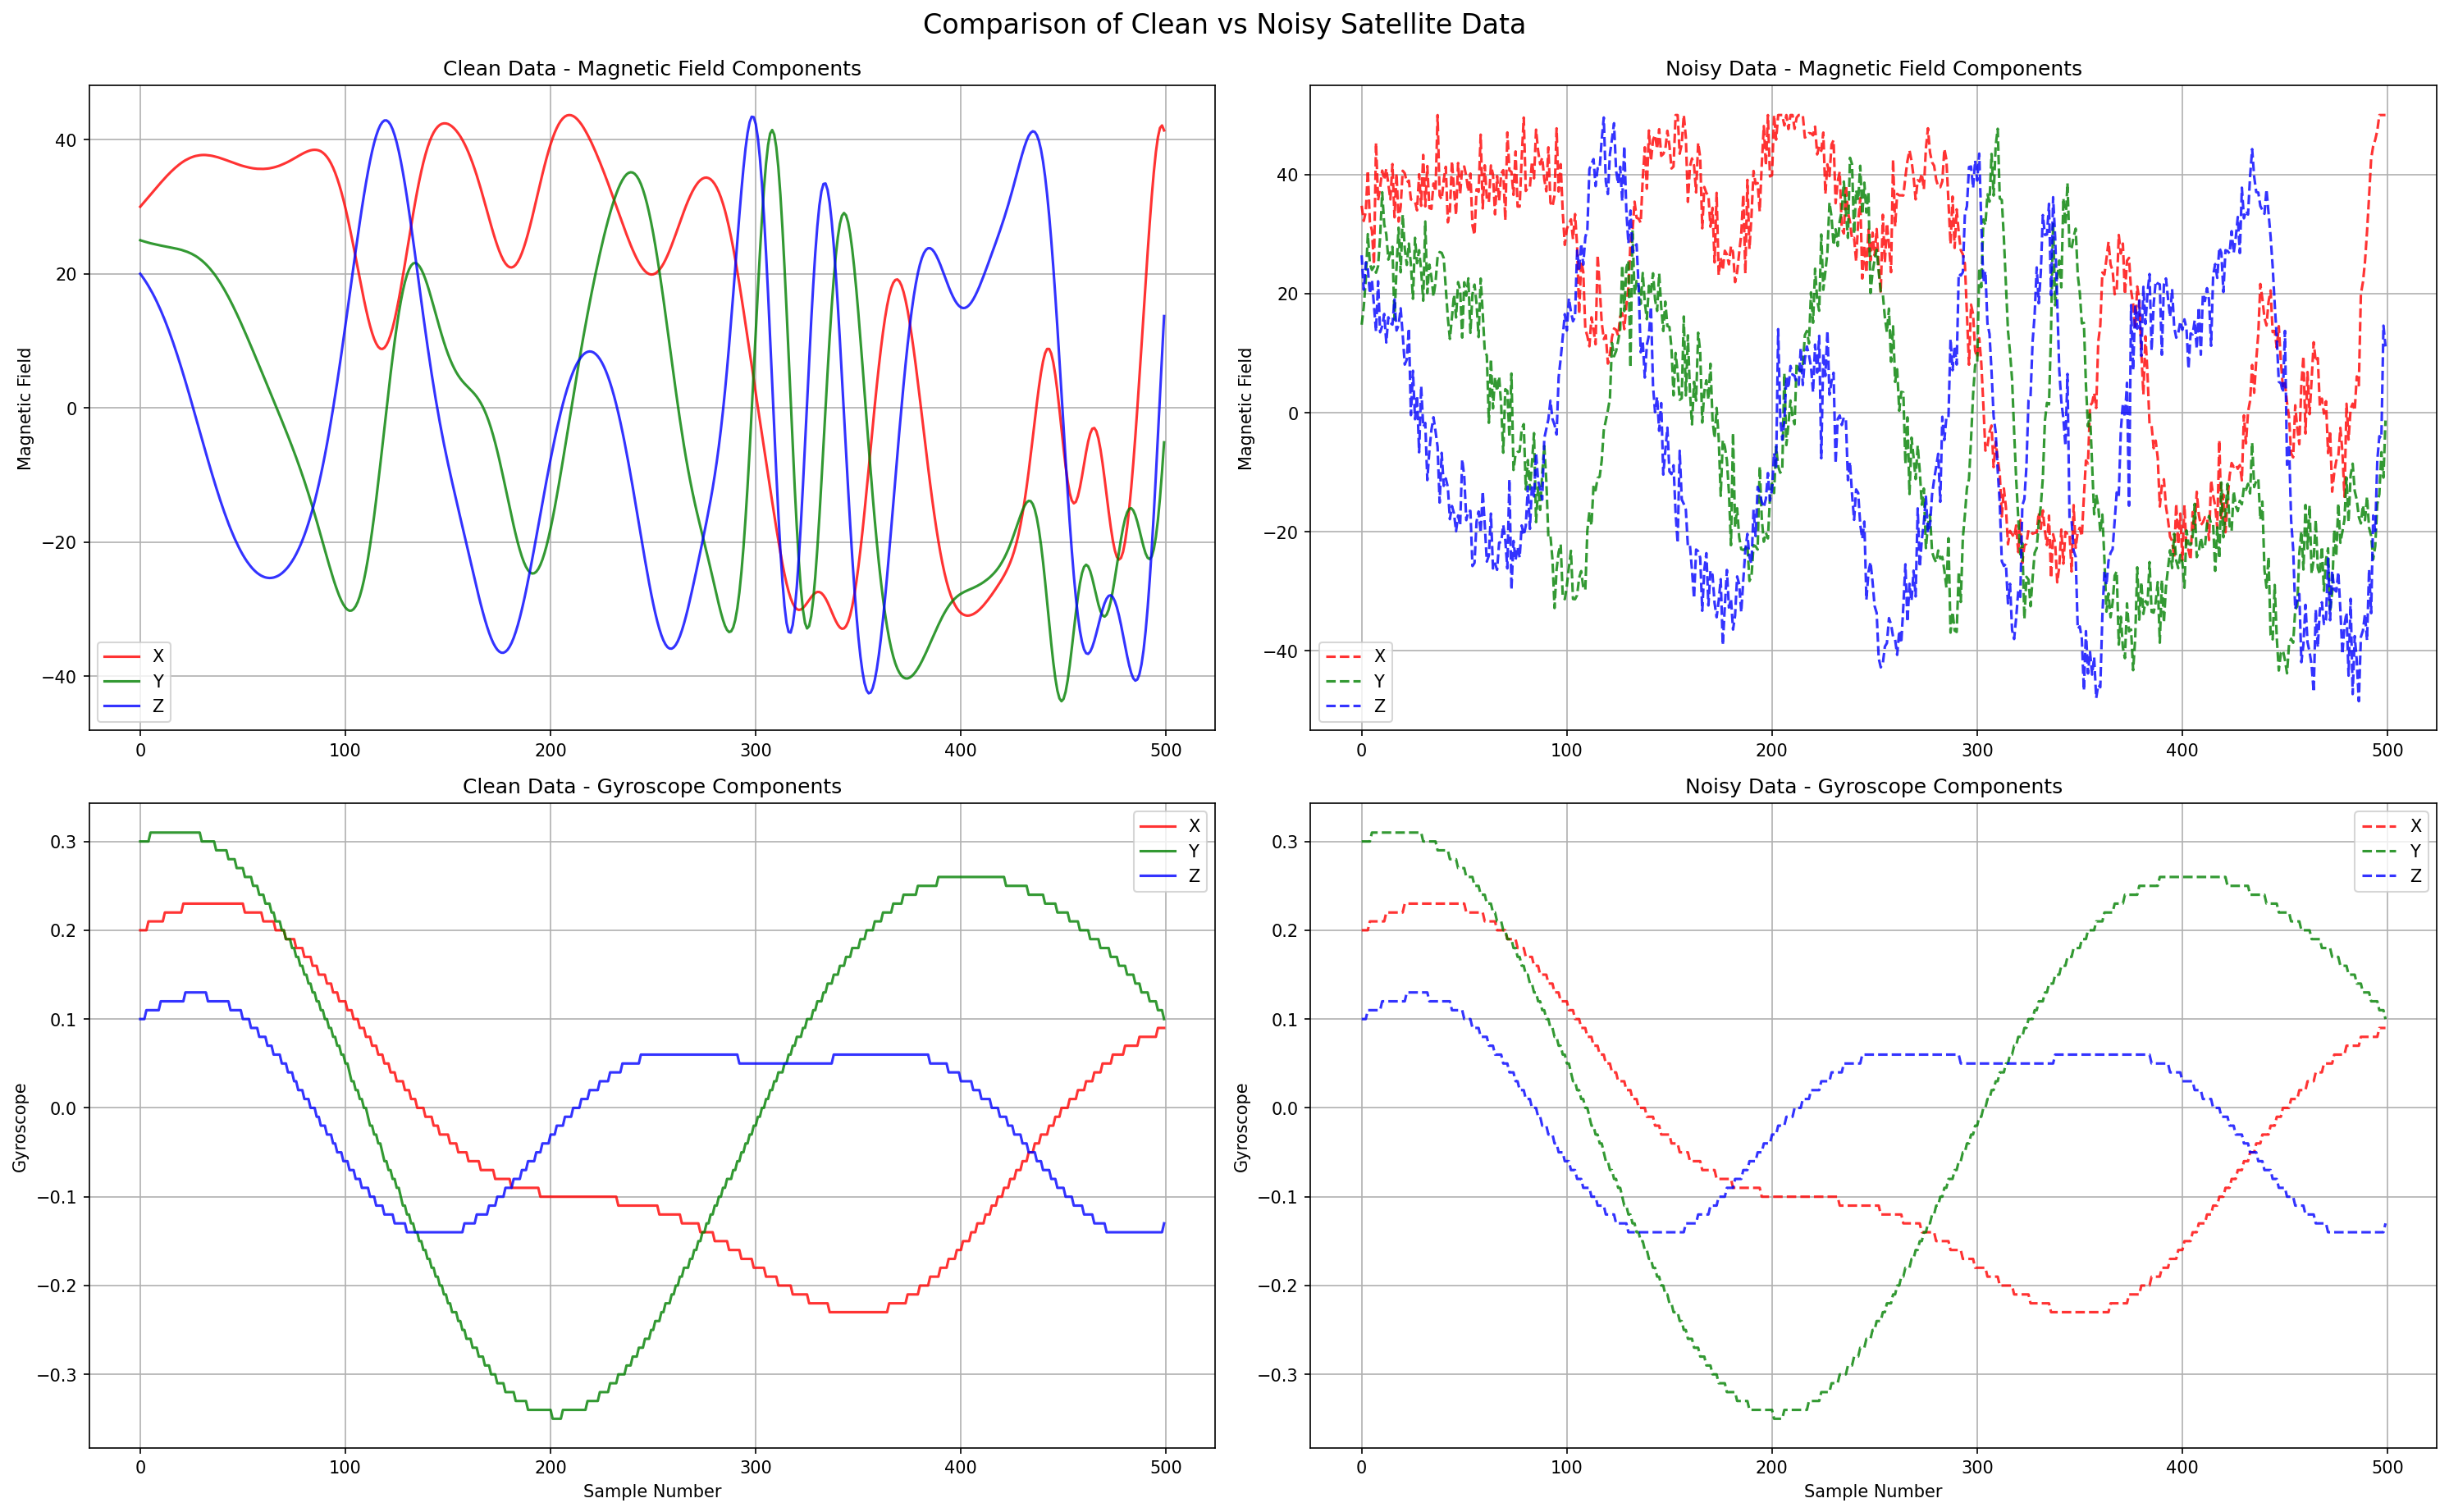


Magnetic Field Statistics - Clean Data:
            mag_x       mag_y       mag_z
count  500.000000  500.000000  500.000000
mean    14.088980   -5.537520   -2.847140
std     24.704601   22.216487   24.232462
min    -32.910000  -43.710000  -42.530000
25%     -8.200000  -24.635000  -24.602500
50%     22.545000   -9.815000   -4.385000
75%     35.785000   15.187500   17.010000
max     43.660000   41.430000   43.410000

Magnetic Field Statistics - Noisy Data:
            mag_x       mag_y       mag_z
count  500.000000  500.000000  500.000000
mean    20.631480   -2.879300   -3.164320
std     22.922454   22.412995   24.239645
min    -28.500000  -43.780000  -48.470000
25%      1.462500  -22.260000  -24.217500
50%     28.360000   -6.675000   -3.800000
75%     39.352500   18.282500   15.767500
max     50.000000   47.700000   49.590000

Gyroscope Statistics - Clean Data:
           gyro_x      gyro_y      gyro_z
count  500.000000  500.000000  500.000000
mean    -0.032300    0.037740   -0.003100


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore

# Read the satellite data files
data_clean = pd.read_csv('satellite_data_clean.txt', 
                        skiprows=1,  
                        header=None,  
                        index_col=False, 
                        names=['pwm', 'mag_x', 'mag_y', 'mag_z', 'gyro_x', 'gyro_y', 'gyro_z', 'voltage'],
                        skipinitialspace=True)

data_noisy = pd.read_csv('satellite_data_aggressive_noise.txt', 
                        skiprows=1,
                        header=None,
                        index_col=False, 
                        names=['pwm', 'mag_x', 'mag_y', 'mag_z', 'gyro_x', 'gyro_y', 'gyro_z', 'voltage'],
                        skipinitialspace=True)

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12), dpi=150)

# Create time array
time = np.arange(len(data_clean))

# Plot magnetic field data - Clean
ax1.plot(time, data_clean['mag_x'], color='red', label='X', alpha=0.8)
ax1.plot(time, data_clean['mag_y'], color='green', label='Y', alpha=0.8)
ax1.plot(time, data_clean['mag_z'], color='blue', label='Z', alpha=0.8)
ax1.set_ylabel('Magnetic Field')
ax1.legend()
ax1.grid(True)
ax1.set_title('Clean Data - Magnetic Field Components')

# Plot magnetic field data - Noisy
ax2.plot(time, data_noisy['mag_x'], color='red', label='X', linestyle='--', alpha=0.8)
ax2.plot(time, data_noisy['mag_y'], color='green', label='Y', linestyle='--', alpha=0.8)
ax2.plot(time, data_noisy['mag_z'], color='blue', label='Z', linestyle='--', alpha=0.8)
ax2.set_ylabel('Magnetic Field')
ax2.legend()
ax2.grid(True)
ax2.set_title('Noisy Data - Magnetic Field Components')

# Plot gyroscope data - Clean
ax3.plot(time, data_clean['gyro_x'], color='red', label='X', alpha=0.8)
ax3.plot(time, data_clean['gyro_y'], color='green', label='Y', alpha=0.8)
ax3.plot(time, data_clean['gyro_z'], color='blue', label='Z', alpha=0.8)
ax3.set_xlabel('Sample Number')
ax3.set_ylabel('Gyroscope')
ax3.legend()
ax3.grid(True)
ax3.set_title('Clean Data - Gyroscope Components')

# Plot gyroscope data - Noisy
ax4.plot(time, data_noisy['gyro_x'], color='red', label='X', linestyle='--', alpha=0.8)
ax4.plot(time, data_noisy['gyro_y'], color='green', label='Y', linestyle='--', alpha=0.8)
ax4.plot(time, data_noisy['gyro_z'], color='blue', label='Z', linestyle='--', alpha=0.8)
ax4.set_xlabel('Sample Number')
ax4.set_ylabel('Gyroscope')
ax4.legend()
ax4.grid(True)
ax4.set_title('Noisy Data - Gyroscope Components')

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a main title to the figure
fig.suptitle('Comparison of Clean vs Noisy Satellite Data', y=1.02, fontsize=16)

plt.show()

# Print statistical comparison
print("\nMagnetic Field Statistics - Clean Data:")
print(data_clean[['mag_x', 'mag_y', 'mag_z']].describe())
print("\nMagnetic Field Statistics - Noisy Data:")
print(data_noisy[['mag_x', 'mag_y', 'mag_z']].describe())
print("\nGyroscope Statistics - Clean Data:")
print(data_clean[['gyro_x', 'gyro_y', 'gyro_z']].describe())
print("\nGyroscope Statistics - Noisy Data:")
print(data_noisy[['gyro_x', 'gyro_y', 'gyro_z']].describe())

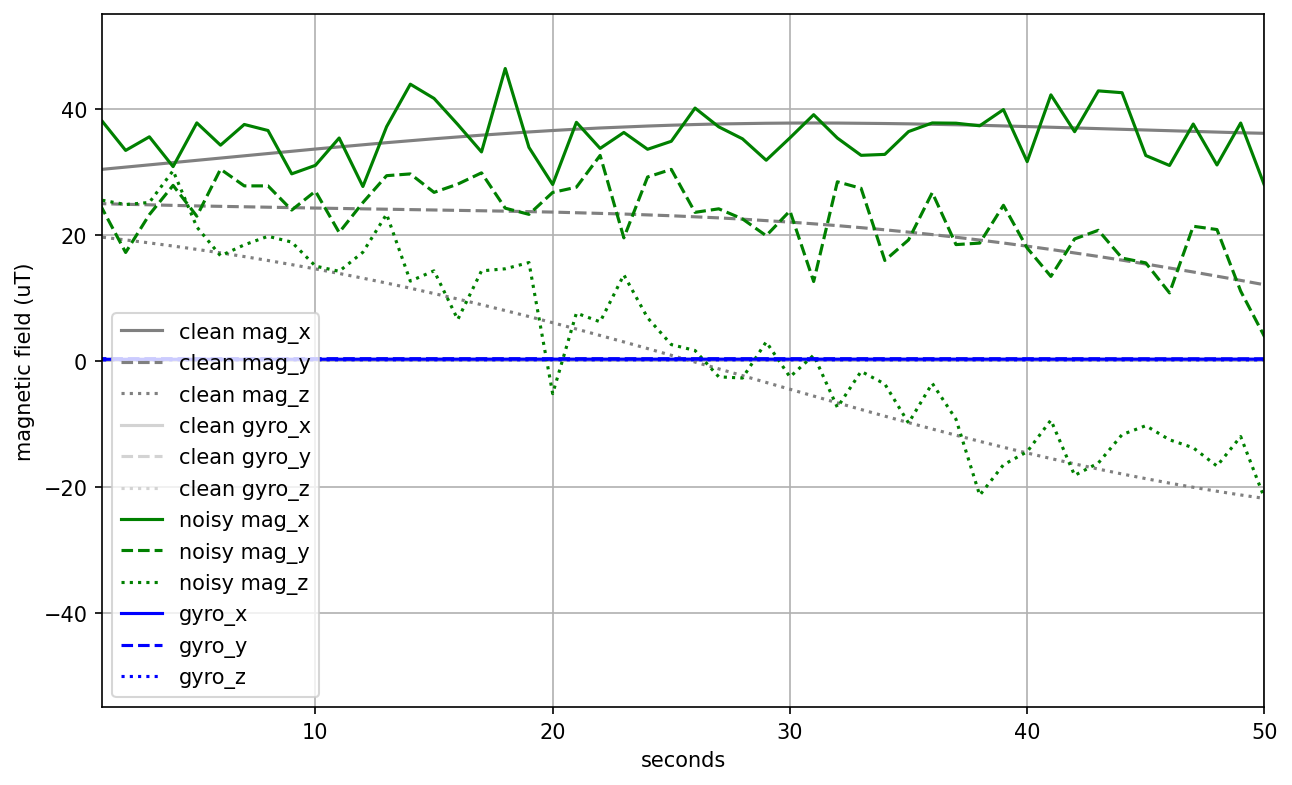

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore

# Read the data files
data = pd.read_csv('satellite_data_clean.txt', 
                        skiprows=1,  
                        header=None,  
                        index_col=False, 
                        names=['pwm', 'mag_x', 'mag_y', 'mag_z', 'gyro_x', 'gyro_y', 'gyro_z', 'voltage'],
                        skipinitialspace=True)

data_2 = pd.read_csv('satellite_data_aggressive_noise.txt', 
                        skiprows=1,
                        header=None,
                        index_col=False, 
                        names=['pwm', 'mag_x', 'mag_y', 'mag_z', 'gyro_x', 'gyro_y', 'gyro_z', 'voltage'],
                        skipinitialspace=True)

# Create the plot
plt.figure(figsize=(10, 6), dpi=150)
plt.xlabel('seconds')
plt.ylabel('magnetic field (uT)')

# Create time array (let's not multiply by 0.1)
time = np.arange(len(data))

# Plot first dataset
plt.plot(time, data['mag_x'], color='grey', label='clean mag_x')
plt.plot(time, data['mag_y'], color='grey', linestyle='--', label='clean mag_y')
plt.plot(time, data['mag_z'], color='grey', linestyle=':', label='clean mag_z')
plt.plot(time, data['gyro_x'], color='lightgrey', label='clean gyro_x')
plt.plot(time, data['gyro_y'], color='lightgrey', linestyle='--', label='clean gyro_y')
plt.plot(time, data['gyro_z'], color='lightgrey', linestyle=':', label='clean gyro_z')
# Plot second dataset
plt.plot(time, data_2['mag_x'], color='green', label='noisy mag_x')
plt.plot(time, data_2['mag_y'], color='green', linestyle='--', label='noisy mag_y')
plt.plot(time, data_2['mag_z'], color='green', linestyle=':', label='noisy mag_z')
plt.plot(time, data_2['gyro_x'], color='blue', label='gyro_x')
plt.plot(time, data_2['gyro_y'], color='blue', linestyle='--', label='gyro_y')
plt.plot(time, data_2['gyro_z'], color='blue', linestyle=':', label='gyro_z')

plt.xlim(1, 50)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# THIS IS THE C++ IMPLEMENTATION OF THE FIRST EKF IN THIS FILE THAT IS RESPONSIVE TO THE NOISY DATA WITHOUT RESETTING THE FILTER
"""
#ifndef RESPONSIVE_EKF_H
#define RESPONSIVE_EKF_H

#pragma once

#include "../constants/constants.h"
#include "../ekf/ekf.hpp"
#include <ArduinoEigen.h>
#include <deque>
#include <array>
#include <cmath>

class ResponsiveEKF : public EKF {
private:
    // Dynamic response parameters
    static constexpr size_t RESPONSE_WINDOW = 5;
    static constexpr double MIN_INNOVATION_GAIN = 0.5;
    static constexpr double MAX_INNOVATION_GAIN = 2.0;
    static constexpr double VELOCITY_THRESHOLD = 0.5;
    static constexpr double BASE_DAMPING = 0.05;

    // History tracking for dynamics
    std::array<std::deque<double>, 6> value_history;
    std::array<std::deque<double>, 6> velocity_history;
    std::array<double, 6> current_gains;
    
    // Base noise matrices
    Eigen::MatrixXd Q_base;
    Eigen::MatrixXd R_base;

    struct DynamicsInfo {
        double velocity;
        double acceleration;
    };

    DynamicsInfo calculate_dynamics(const std::deque<double>& values) {
        DynamicsInfo result = {0.0, 0.0};
        
        if (values.size() < 3) {
            return result;
        }

        // Calculate velocities
        std::vector<double> velocities;
        for (size_t i = 1; i < values.size(); ++i) {
            velocities.push_back(values[i] - values[i-1]);
        }
        
        // Calculate accelerations
        std::vector<double> accelerations;
        for (size_t i = 1; i < velocities.size(); ++i) {
            accelerations.push_back(velocities[i] - velocities[i-1]);
        }

        // Calculate means
        result.velocity = std::accumulate(velocities.begin(), velocities.end(), 0.0) / velocities.size();
        result.acceleration = std::accumulate(accelerations.begin(), accelerations.end(), 0.0) / accelerations.size();

        return result;
    }

    void update_gains(const Eigen::VectorXd& measurement) {
        for (int i = 0; i < 6; ++i) {
            // Update value history
            if (value_history[i].size() >= RESPONSE_WINDOW) {
                value_history[i].pop_front();
            }
            value_history[i].push_back(measurement(i));

            // Calculate dynamics
            auto dynamics = calculate_dynamics(value_history[i]);

            // Update velocity history
            if (velocity_history[i].size() >= RESPONSE_WINDOW) {
                velocity_history[i].pop_front();
            }
            velocity_history[i].push_back(dynamics.velocity);

            // Calculate velocity trend
            if (velocity_history[i].size() >= 2) {
                double velocity_trend = 0.0;
                for (size_t j = 1; j < velocity_history[i].size(); ++j) {
                    velocity_trend += velocity_history[i][j] - velocity_history[i][j-1];
                }
                velocity_trend /= (velocity_history[i].size() - 1);

                // Update gain based on dynamics
                if (std::abs(velocity_trend) > VELOCITY_THRESHOLD) {
                    current_gains[i] = MAX_INNOVATION_GAIN;
                } else {
                    current_gains[i] = MIN_INNOVATION_GAIN;
                }

                // Additional boost for acceleration
                if (std::abs(dynamics.acceleration) > VELOCITY_THRESHOLD) {
                    current_gains[i] *= 1.5;
                }
            }
        }
    }

    Eigen::Matrix<double, 6, 1> f(const Eigen::Matrix<double, 6, 1> &x) override {
        Eigen::Matrix<double, 6, 1> dxdt;
        
        // Calculate adaptive damping
        std::array<double, 6> damping;
        for (int i = 0; i < 6; ++i) {
            damping[i] = BASE_DAMPING / current_gains[i];
        }

        dxdt(0) = -x(2) * x(4) + x(1) * x(5) - damping[0] * x(0);
        dxdt(1) = x(2) * x(3) - x(0) * x(5) - damping[1] * x(1);
        dxdt(2) = -x(1) * x(3) + x(0) * x(4) - damping[2] * x(2);
        dxdt(3) = -x(4) * x(5) - damping[3] * x(3);
        dxdt(4) = x(3) * x(5) - damping[4] * x(4);
        dxdt(5) = -x(3) * x(4) / 3 - damping[5] * x(5);
        
        return dxdt;
    }

    void predict(const Eigen::MatrixXd &J) override {
        // Predict state using RK4
        state = rk4(state, dt, 0.0, dt);
        
        // Adjust process noise based on current gains
        Eigen::MatrixXd Q_adjusted = Q_base;
        for (int i = 0; i < 6; ++i) {
            for (int j = 0; j < 6; ++j) {
                Q_adjusted(i,j) *= (current_gains[i] * current_gains[j]);
            }
        }
        
        // Update covariance
        covariance = J * covariance * J.transpose() + Q_adjusted;
        
        // Ensure symmetry
        covariance = (covariance + covariance.transpose()) * 0.5;
    }

    void correct() override {
        // Adjust measurement noise based on gains
        Eigen::MatrixXd R_adjusted = R_base;
        for (int i = 0; i < 6; ++i) {
            for (int j = 0; j < 6; ++j) {
                R_adjusted(i,j) /= (current_gains[i] * current_gains[j]);
            }
        }
        
        // Calculate Kalman gain
        Eigen::MatrixXd S = H_d * covariance * H_d.transpose() + R_adjusted;
        Eigen::MatrixXd K = covariance * H_d.transpose() * S.inverse();
        
        // Update state
        state = state + K * (Z - H_d * state);
        
        // Update covariance
        Eigen::MatrixXd I = Eigen::MatrixXd::Identity(state.size(), state.size());
        covariance = (I - K * H_d) * covariance;
        
        // Ensure symmetry
        covariance = (covariance + covariance.transpose()) * 0.5;
    }

    Eigen::MatrixXd CalculateJacobian() override {
        // Calculate adaptive damping
        std::array<double, 6> damping;
        for (int i = 0; i < 6; ++i) {
            damping[i] = BASE_DAMPING / current_gains[i];
        }

        Eigen::MatrixXd J(6, 6);
        
        const double Bx = state(0), By = state(1), Bz = state(2);
        const double wx = state(3), wy = state(4), wz = state(5);
        
        J << -damping[0], wz, -wy, 0, -Bz, By,
             -wz, -damping[1], wx, Bz, 0, -Bx,
             wy, -wx, -damping[2], -By, Bx, 0,
             0, 0, 0, -damping[3], -wz, -wy,
             0, 0, 0, wz, -damping[4], wx,
             0, 0, 0, -wx/3, -wy/3, -damping[5];
        
        return J;
    }

public:
    ResponsiveEKF() : EKF() {
        // Initialize histories
        for (int i = 0; i < 6; ++i) {
            value_history[i] = std::deque<double>();
            velocity_history[i] = std::deque<double>();
            current_gains[i] = 1.0;
        }
        
        // Initialize base noise matrices
        Q_base = Eigen::MatrixXd::Zero(6, 6);
        Q_base.diagonal() << 0.05, 0.05, 0.05, 0.01, 0.01, 0.01;
        
        R_base = Eigen::MatrixXd::Zero(6, 6);
        R_base.diagonal() << 0.8, 0.8, 0.8, 0.1, 0.1, 0.1;
    }

    void initialize(double delta_t,
                   const Eigen::VectorXd &initial_state,
                   const Eigen::MatrixXd &initial_covariance,
                   const Eigen::MatrixXd &process_noise_covariance,
                   const Eigen::MatrixXd &Rd,
                   const Eigen::MatrixXd &Hd) override {
        EKF::initialize(delta_t, initial_state, initial_covariance,
                       process_noise_covariance, Rd, Hd);
        
        // Store base noise matrices
        Q_base = process_noise_covariance;
        R_base = Rd;
    }

    void step() override {
        update_gains(Z);
        Eigen::MatrixXd J = CalculateJacobian();
        predict(J);
        correct();
    }
};

#endif // RESPONSIVE_EKF_H
"""

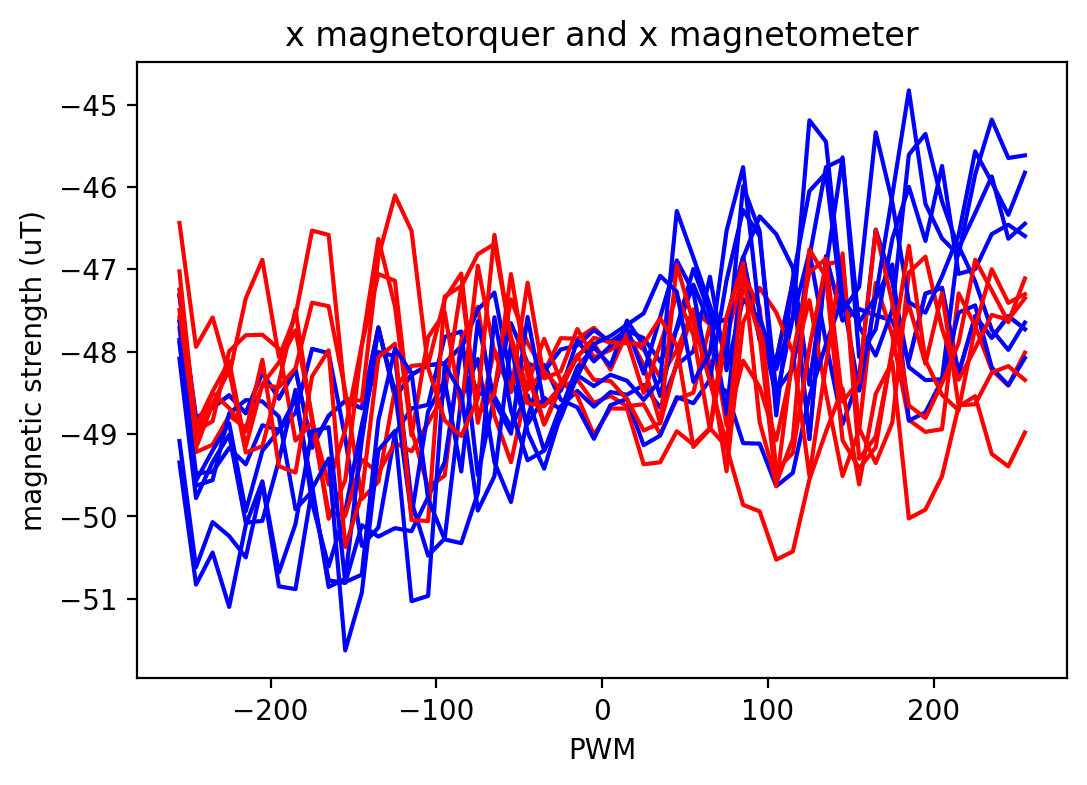

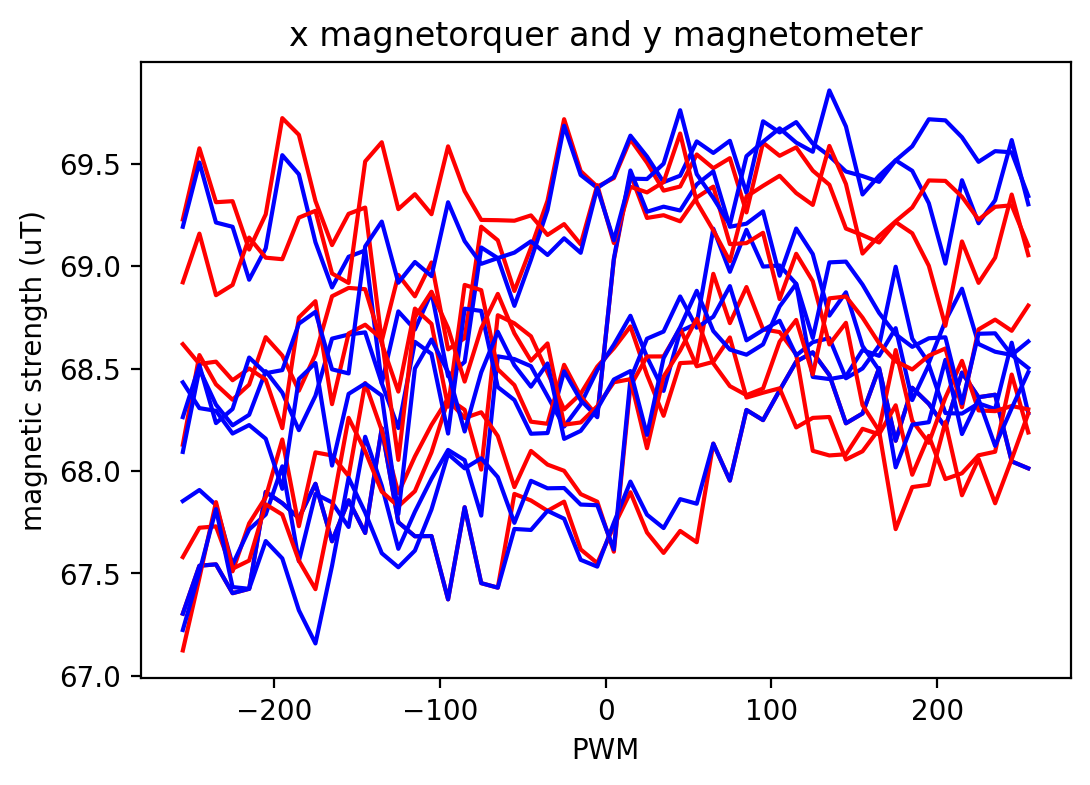

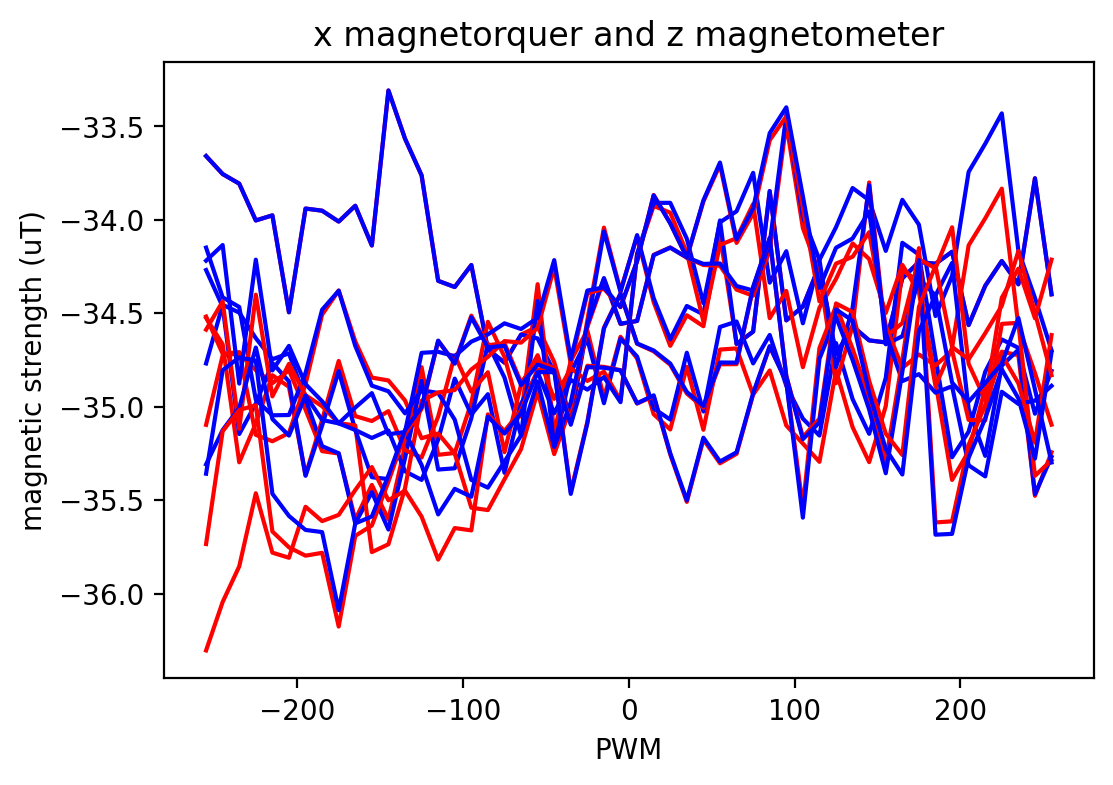

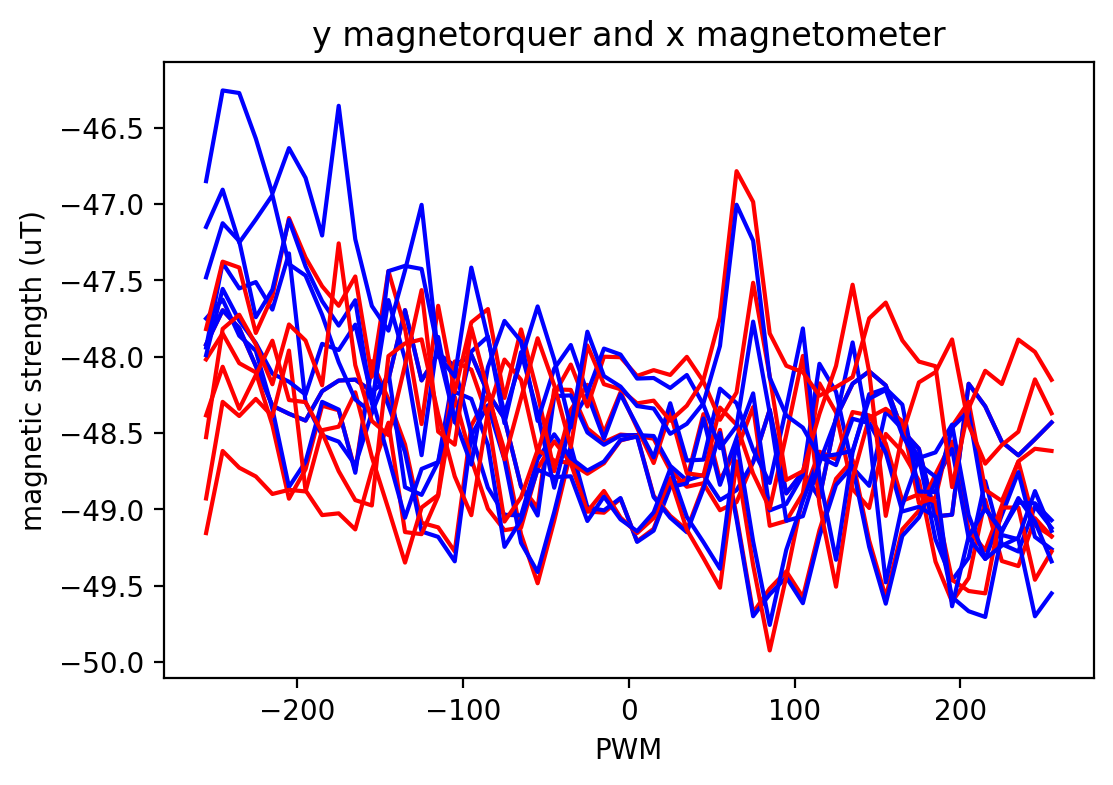

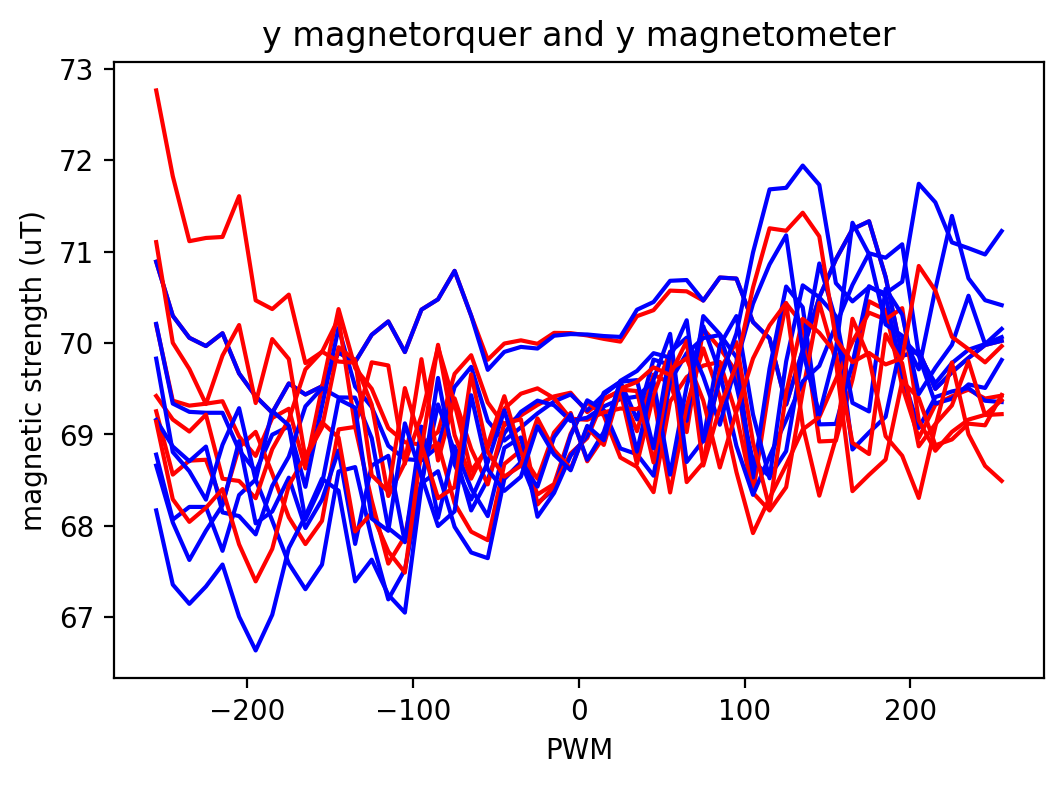

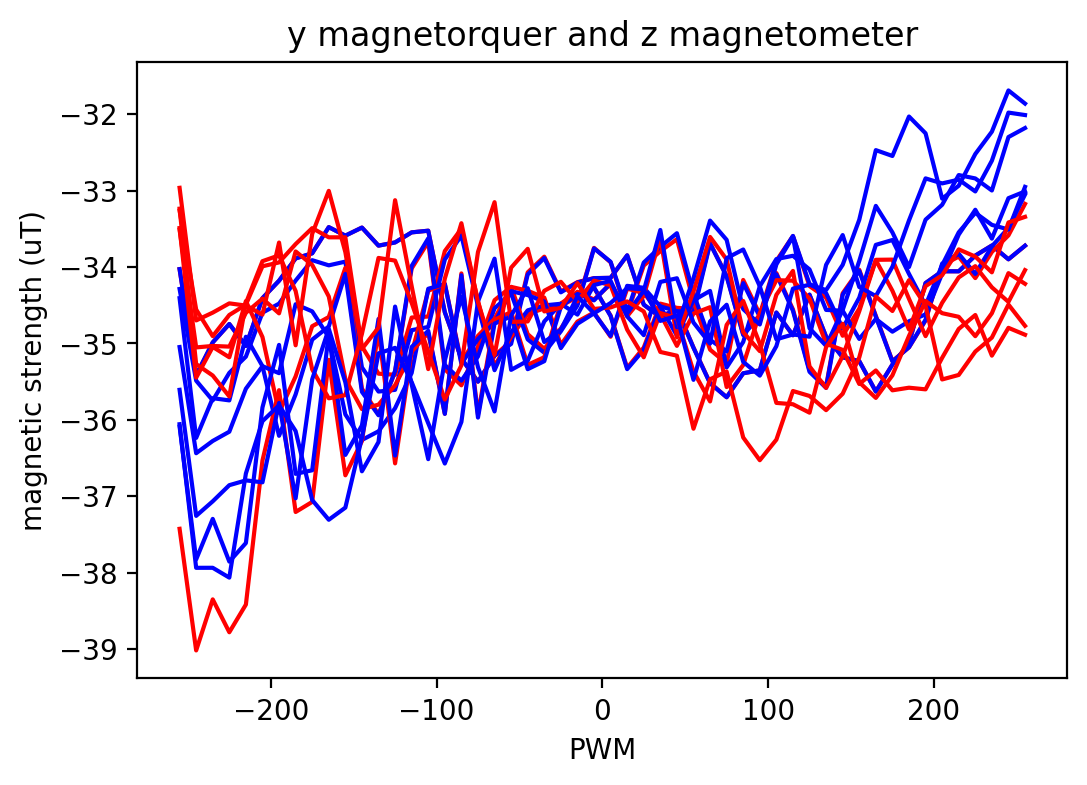

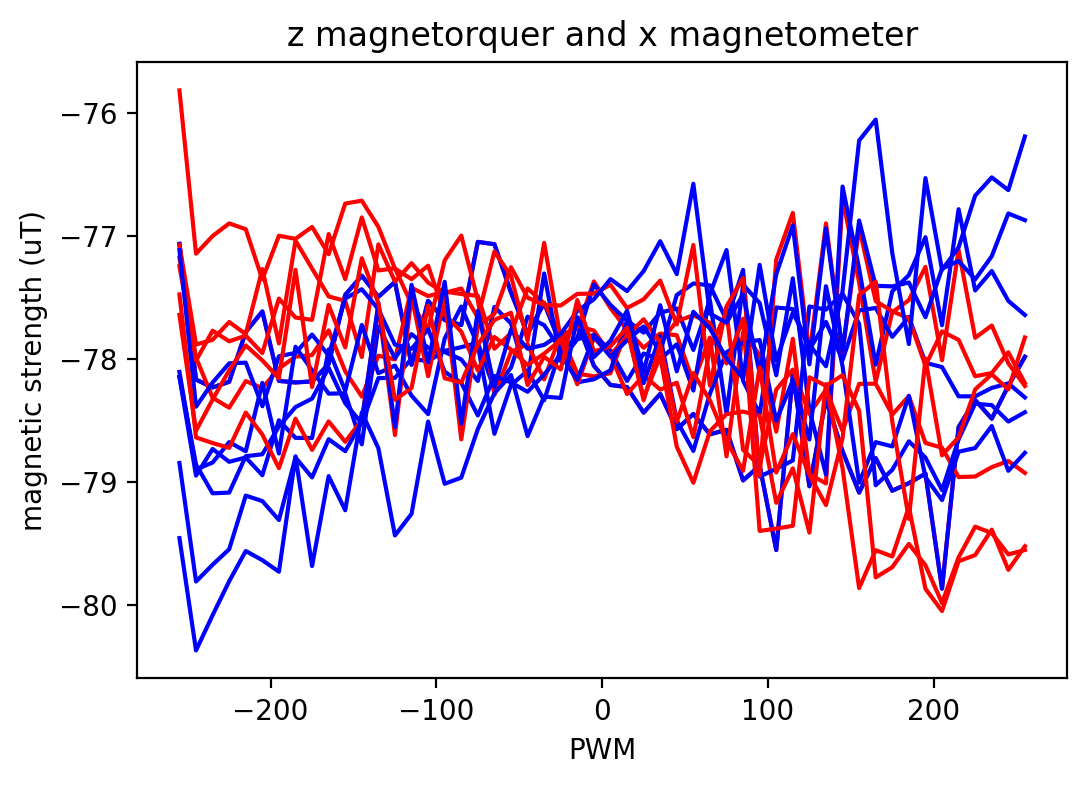

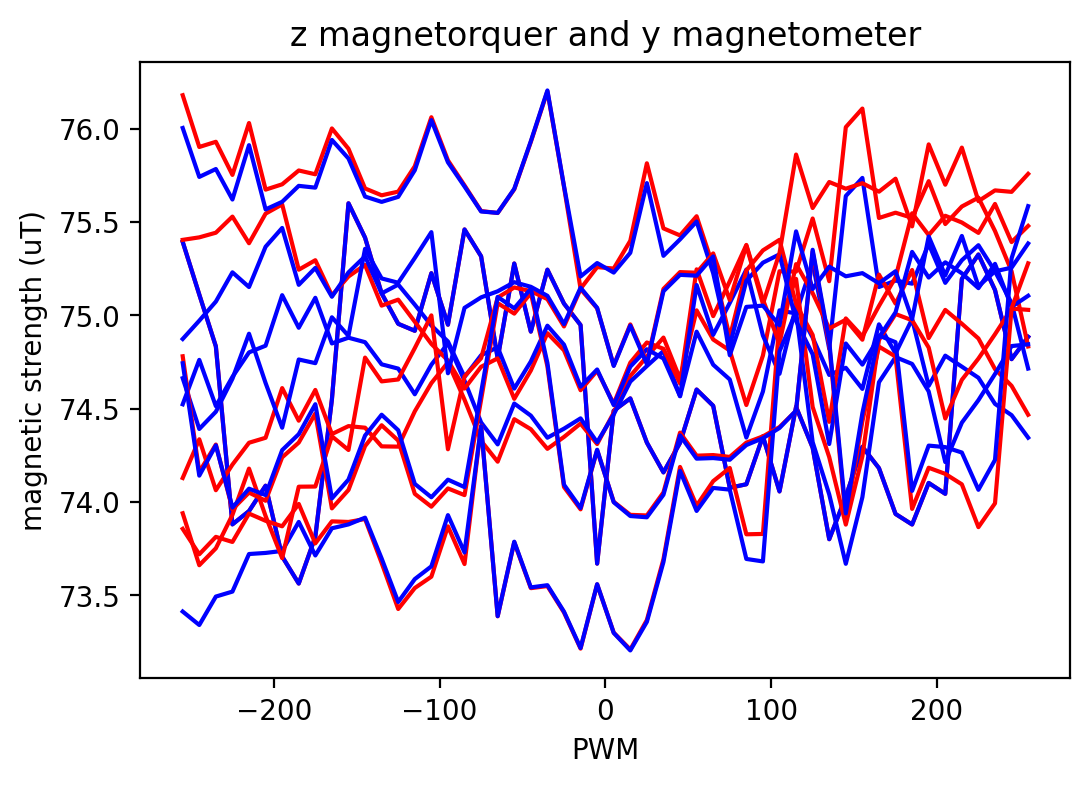

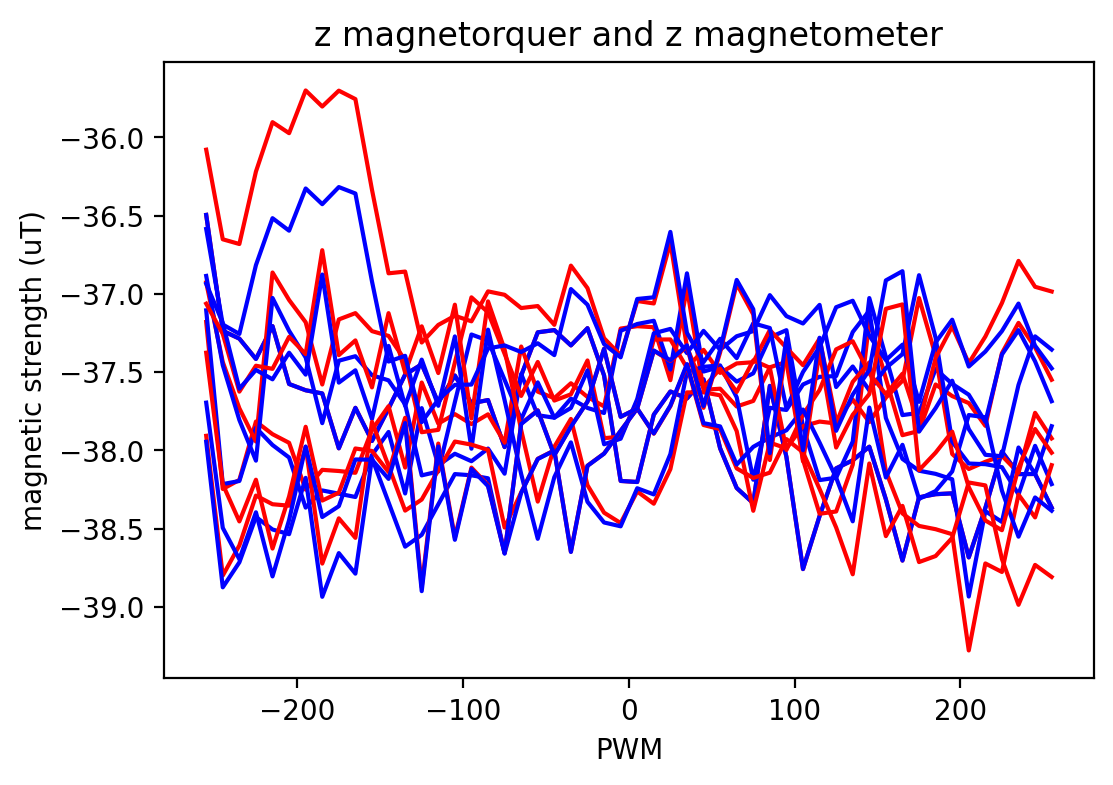

In [35]:
data = pd.read_csv('cubesat_imus.csv').drop(columns='Unnamed: 0')
data_simple = pd.read_csv('cubesat_imus_simple.csv').drop(columns='Unnamed: 0')

dirs = ['x','y','z']

for torq in dirs:
	for mag in dirs:
		# torq='y'
		# mag='z'
		plt.figure(figsize=(6,4), dpi=200)
		plt.title(torq+' magnetorquer and '+mag+' magnetometer')
		plt.ylabel('magnetic strength (uT)')
		plt.xlabel('PWM')
		for i in np.arange(3.6, 4.2, 0.1):
			i = str(round(i,2))

			# plt.plot(data['pwm'], data[torq+'torq_'+mag+'mag_'+i], label=i, color='green')
			plt.plot(data['pwm'], data[torq+'torq_'+mag+'mag_'+i] - data[torq+'torq_'+mag+'offset_'+i], label=i, color='red')
			plt.plot(data['pwm'], data[torq+'torq_'+mag+'mag_'+i] - data_simple[torq+'torq_'+mag+'offset_'+i], label=i, color='blue')

		plt.savefig(torq+'torq_'+mag+'mag', dpi=200)

# plt.legend()
# plt.plot(data['pwm'], data['xtorq_ymag']-data['xtorq_yoffset'])

In [36]:
'''
Processsing testing data for the breadboard (same PWM, varying voltage with dial)
'''

data = pd.read_csv(str(os.getcwd())+'/data/test.txt', header=1, index_col = False, names=['pwm', 'mag_x', 'mag_y', 'mag_z', 'offset_x', 'offset_y', 'offset_z', 'voltage'])

# plt.figure(figsize=(6,4), dpi=200)
# plt.plot(pd.Series(data.index), zscore(data.mag_y-data.offset_y))
# plt.plot(pd.Series(data.index), zscore(data.voltage))
# plt.xlabel("indexes")

plt.figure(figsize=(6,4), dpi=200)
plt.plot(pd.Series(data.index), data.mag_y)
plt.xlabel("indexes")
plt.ylabel('uT')

plt.figure(figsize=(6,4), dpi=200)
plt.plot(pd.Series(data.index), data.voltage)
plt.xlabel("indexes")
plt.ylabel('V')


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\Johha\\OneDrive\\Desktop\\2-7-25\\acs_test_code/data/test.txt'

In [ ]:
path = str(os.getcwd())+"/data/10.17.2024_voltimu_dataset/"
# data = pd.read_csv(path+'bread_voltimu_3.6v.txt', header=1, index_col = False, names=['pwm', 'mag_x', 'mag_y', 'mag_z', 'offset_x', 'offset_y', 'offset_z', 'voltage'])
# data['mag_y'].head(1)


In [ ]:
'''
Processsing testing data for the breadboard (vary PWM, same voltage)
'''

path = str(os.getcwd())+"/data/10.17.2024_voltimu_dataset/"

slopes = []

pwmY_ox_1 = 8.60013482e-03;
pwmY_ox_2 = -2.04542449e-06;
pwmY_ox_3 = 6.14475215e-09;
pwmY_oy_1 = -2.37677372e-01;
pwmY_oy_2 = -3.66292599e-07;
pwmY_oy_3 = 7.25220153e-08;
pwmY_oz_1 = -1.47995640e-02;
pwmY_oz_2 = 1.97761126e-07;
pwmY_oz_3 = 2.85273223e-08;

plt.figure(figsize=(6,4), dpi=200)
for i in np.arange(3.6, 4.2, .1): 
	# print(i)
	data = pd.read_csv(path+'bread_voltimu_'+str(round(i,2))+'v.txt', header=1, index_col = False, names=['pwm', 'mag_x', 'mag_y', 'mag_z', 'offset_x', 'offset_y', 'offset_z', 'voltage'])

	# data_2 = pd.read_csv(path+'voltimugraph_'+str(round(i,2))+'v_test2.txt', header=1, index_col = False, names=['pwm', 'mag_x', 'mag_y', 'mag_z', 'offset_x', 'offset_y', 'offset_z', 'voltage'])
	slopes.append(-(float(data['mag_y'].head(1)) - float(data['mag_y'].tail(1)))/510)
	voltage = data['voltage'].mean()
	# voltage_2 = data_2['voltage'].mean()

	# data.offset_y = (pwmY_oy_1 * data.pwm) + (pwmY_oy_2 * pow(data.pwm, 2)) + (pwmY_oy_3 * pow(data.pwm, 3))

	print(data.voltage.mean())
	offset_x, offset_y, offset_z = calc_softirons(data.pwm, data.voltage.mean())

	plt.plot(pd.Series(data.index), data.mag_y - offset_y, label = str(round(voltage,2)))
	# plt.plot(pd.Series(data.index), data.mag_y, label = str(round(voltage,2)))
	# plt.plot(pd.Series(data_2.index), data_2.mag_y - data_2.offset_y, label = str(round(voltage_2,2)))
	# plt.plot(pd.Series(data.index), data.mag_y, label = str(round(voltage,2)))
	plt.xlabel("indexes")
	plt.ylabel("uT")

# data = pd.read_csv(path+'voltimugraph_4.0v_slow.txt', header=1, index_col = False, names=['pwm', 'mag_x', 'mag_y', 'mag_z', 'offset_x', 'offset_y', 'offset_z', 'voltage'])
# plt.plot(pd.Series(data.index)*10, data.mag_y, label = '4.0v_slow')
plt.legend(bbox_to_anchor=[1, 1])

plt.figure(figsize=(6,4), dpi=200)
plt.plot(pd.Series(data.index), data.voltage)

# mag=[]
# volt=[]
# plt.figure(figsize=(6,4), dpi=200)
# for i in np.arange(3.60, 4.2, .05): 
#	 data = pd.read_csv(path+'voltimugraph_'+str(round(i,2))+'v.txt', header=1, index_col = False, names=['pwm', 'mag_x', 'mag_y', 'mag_z', 'offset_x', 'offset_y', 'offset_z', 'voltage'])
#	 mag.append(data['mag_y'][250])
#	 volt.append(data['voltage'].mean())

# plt.scatter(volt, mag)
# plt.xlabel("voltage")
# plt.ylabel("uT")

plt.figure(dpi=200)
plt.plot(np.arange(3.6, 4.2, .1), slopes)
(slopes[-1] - slopes[0]) / 0.6


In [ ]:
# data = pd.read_csv(str(os.getcwd())+'/data/airbearingrig_tests/test28_oct2024.txt', header=1, index_col = False, names=['error', 'current', 'PWM', 'mag_x', 'mag_z', 'mag_y', 'battery'])

# data_off = pd.read_csv(str(os.getcwd())+'/data/airbearingrig_tests/test66_dec2024.txt', header=0, index_col = False, names=['error', 'current', 'PWM', 'mag_x', 'mag_y', 'mag_z', 'hardiron_x', 'hardiron_y', 'hardiron_z', 'softiron_x', 'softiron_y', 'softiron_z', 'voltage'])
data_on = pd.read_csv(str(os.getcwd())+'/data/airbearingrig_tests/test66_dec2024.txt', header=0, index_col = False, names=['error', 'current', 'PWM', 'mag_x', 'mag_y', 'mag_z', 'hardiron_x', 'hardiron_y', 'hardiron_z', 'softiron_x', 'softiron_y', 'softiron_z', 'voltage'])

# data_on = pd.read_csv(str(os.getcwd())+'/data/airbearingrig_tests/test26_oct2024.txt', header=0, index_col = False, names=['error', 'current', 'PWM', 'mag_x', 'mag_z', 'mag_y', 'voltage'])

# data = pd.read_csv(str(os.getcwd())+'/data/test23_sep2-024.txt', header=1, index_col = False, names=['pwm', 'mag_x', 'mag_y', 'mag_z', 'offset_x', 'offset_y', 'offset_z', 'voltage'])
# data_off

In [ ]:
# plt.figure(figsize=(6,4), dpi=200)
# plt.plot(pd.Series(data.index), data.PWM)
# # plt.title("Test 17 PWM values")
# plt.xlabel("indexes")
# plt.ylabel("PWM")

# plt.figure(figsize=(6,4), dpi=200)
# plt.plot(pd.Series(data_off.index)*0.1, data_off.mag_x, label='x')
# plt.plot(pd.Series(data_off.index)*0.1, data_off.mag_y, label='y')
# plt.plot(pd.Series(data_off.index)*0.1, data_off.mag_z, label='z')
# # plt.plot(pd.Series(data.index), data.mag_x - data.offset_x, color='blue')
# # plt.plot(pd.Series(data.index), data.mag_y - data.offset_y, color='blue')
# # plt.plot(pd.Series(data.index), data.mag_z - data.offset_z, color='blue')
# # plt.title("Test 17 Mag values") 
# plt.xlabel("sec")
# plt.ylabel("uT")
# plt.legend()

# plt.figure(figsize=(6,4), dpi=200)
# plt.plot(pd.Series(data_off.index)*0.1, data_off.PWM)
# plt.xlabel("sec")
# plt.ylabel("PWM")

plt.figure(figsize=(6,4), dpi=200)
# plt.plot(pd.Series(data_on.index)*0.1, data_on.mag_x - data_on.hardiron_x - data_on.softiron_x, label='x')
# plt.plot(pd.Series(data_on.index)*0.1, data_on.mag_y - data_on.hardiron_y - data_on.softiron_y, label='y')
# plt.plot(pd.Series(data_on.index)*0.1, data_on.mag_z - data_on.hardiron_z - data_on.softiron_z, label='z')
# plt.plot(pd.Series(data_on.index)*0.1, data_on.mag_x, label='x')
plt.plot(pd.Series(data_on.index)*0.1, data_on.mag_y, label='y')
# plt.plot(pd.Series(data_on.index)*0.1, data_on.mag_z, label='z')
plt.xlabel("sec")
plt.xlim(80,90)
plt.ylabel("uT")
plt.legend()

plt.figure(figsize=(6,4), dpi=200)
plt.plot(pd.Series(data_on.index)*0.1, data_on.PWM)
plt.xlabel("sec")
plt.xlim(80,90)
plt.ylabel("PWM")

# plt.figure(figsize=(6,4), dpi=200)
# plt.plot(pd.Series(data.index), data.battery)


In [ ]:
# data = data.iloc[2000:4000]

data_off['angle'] = np.arctan(data_off.mag_x/data_off.mag_y) * 180 / np.pi
# data['ang_velocity'] = np.gradient(data['angle'])
# data['ang_accel'] = np.gradient(data['ang_velocity'])

plt.figure(figsize=(6,4), dpi=200)
plt.plot(pd.Series(data_off.index)*.1, data_off.angle, label='angle', color='black')
# plt.plot(pd.Series(data.index), data.PWM, label='pwm')
# plt.plot(pd.Series(data.index), data.ang_velocity)
# plt.plot(pd.Series(data.index), data.ang_accel)
plt.xlabel("sec")
plt.ylabel("deg")
plt.legend()
# plt.ylabel("deg")
# plt.ylim((-5,5))

plt.figure(figsize=(6,4), dpi=200)
plt.plot(pd.Series(data_off.index)*0.1, data_off.PWM, color='r')
plt.xlabel("sec")
plt.ylabel("PWM")

data_on['angle'] = np.arctan(data_on.mag_x/data_on.mag_y) * 180 / np.pi
plt.figure(figsize=(6,4), dpi=200)
plt.plot(pd.Series(data_on.index)*.1, data_on.angle, label='angle', color='black')
plt.xlabel("sec")
plt.ylabel("deg")
plt.legend()

plt.figure(figsize=(6,4), dpi=200)
plt.plot(pd.Series(data_on.index)*0.1, data_on.PWM, color='r')
plt.xlabel("sec")
plt.ylabel("PWM")

In [ ]:
import os
import pandas as pd
import numpy as np

# Define the path for the new file
file_path = str(os.getcwd()) + '/softiron_testing_linear.txt'

# Load the text file and assign column names
columns = ['PWM', 'mag_x', 'mag_y', 'mag_z', 'x_offset', 'y_offset', 'z_offset']
data = pd.read_csv(file_path, header=None, names=columns, delim_whitespace=True)

# Process the data
pwms = data['PWM'].tolist()
mag_x = data['mag_x'].tolist()
mag_y = data['mag_y'].tolist()
mag_z = data['mag_z'].tolist()
offsets_x = data['x_offset'].tolist()
offsets_y = data['y_offset'].tolist()
offsets_z = data['z_offset'].tolist()

# Create a DataFrame for the processed results
processed_data = pd.DataFrame({
	'pwm': pwms,
	'z_torq_xmag': mag_x,
	'z_torq_xoffset': offsets_x,
	'z_torq_ymag': mag_y,
	'z_torq_yoffset': offsets_y,
	'z_torq_zmag': mag_z,
	'z_torq_zoffset': offsets_z
})

# Save the processed DataFrame to a CSV file
processed_data.to_csv('softiron_processed_data.csv', index=False)

# Visualization (optional, based on your requirements)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(processed_data['pwm'], processed_data['z_torq_xmag'], label='X Mag')
plt.plot(processed_data['pwm'], processed_data['z_torq_ymag'], label='Y Mag')
plt.plot(processed_data['pwm'], processed_data['z_torq_zmag'], label='Z Mag')

plt.title("Magnetometer Data Visualization")
plt.xlabel("PWM")
plt.ylabel("Magnetometer Values (uT)")
plt.legend()
plt.grid()
plt.show()

# Print the processed DataFrame for verification
print(processed_data)
